* Description of function from this notebook: https://github.com/blue-yonder/tsfresh/blob/da06274958a10d28f96c19488af43052dc5a26ed/tsfresh/feature_extraction/feature_calculators.py#L33
* Another description: https://tsfresh.readthedocs.io/en/latest/api/tsfresh.feature_extraction.html

__CLEANING MESSY DATA__: https://github.com/cleanlab/cleanlab
More about objective for regression: https://xgboost.readthedocs.io/en/stable/parameter.html

In [25]:
from copy import deepcopy
import numpy as np
import pandas as pd
import itertools
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.model_selection import KFold, TimeSeriesSplit, train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error, mean_absolute_error, r2_score
from collections import Counter
from time import localtime, strftime
import math
import tsfresh.feature_extraction.feature_calculators as fc
# https://tsfresh.readthedocs.io/en/latest/text/list_of_features.html
from helper import ( prepare_data, train_test_shuffle_split, train_test_seq_split, print_folds_stats )

from xgboost import XGBRegressor

from matplotlib import pyplot as plt
plt.style.use('ggplot')     # 'fivethirtyeight'
%matplotlib inline
%load_ext autoreload
%autoreload 2
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 150)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Part 1. Tsfresh and other features

In [2]:
events = { 'tex2step' : {
                            'file': 'data/2step_20221229.csv',
                            'features': ['Num1', 'Num2', 'Num3', 'Num4',]
                         }
        }
event = 'tex2step'

In [3]:
file     = events[ event ]['file']
features = events[ event ]['features']

df = pd.read_csv( file, encoding='utf-8' )
print('Shape of data:', df.shape, '\n')

Shape of data: (2256, 9) 



## 1.1 Horizontally aggregated tsfresh features (SEE APPENDIX FOR VERTICAL AGGREGATION)

All possible feature functions were receved by running:
```
import tsfresh
dir(fc)
```
__It is manually confirmed that all such possible feature functions are calculated / utilized in the code below except for the following functions that were droppped for various reasons__:
* change_quantiles - not sure if helpful (sets lower and upper quantiles and applies numpy func (mean, var, std etc.) to the corridor between the new quantiles)
* scipy.signal.cwt - too complicated (requires multiple arguments including a special function!)
* scipy.signal.find_peaks_cwt - same
* cwt_coefficients, number_cwt_peaks - too complicated (requires an array of widths and two int numbers as additional args)
* friedrich_coefficients() - return only one coeff from _estimate_friedrich_coefficients(); better use latter
* lempel_ziv_complexity - for string only
* linear_trend_timewise - as input, requires a time series with datetime-typed index
* matrix_profile() - matrixprofile installed w/pip, but ImportError: Could not import matrixprofile
* partial_autocorrelation - pacf is already returned which is the underlying func for partial_correlation()
* percentage_of_reoccurring_values_to_all_values - will always be 0
* query_similarity_count - too complicated, needs non-trivial three parameters
* range_count(x, min, max) - same as count_below() and count_above()
* spkt_welch_density - almost the same as welch
* symmetry_looking - not sure I understand this
* value_count - counting specific values: they will always be 0 or 1, depending on the value
* sample_entropy - all nans or inf
* mp - module matrixprofile

In [11]:
# functions to call on a time series to create additional features
funcs = [    
    'acf',                                         # np.mean to get 1 num
    'absolute_maximum',
    'approximate_entropy',
    'permutation_entropy',
    'ar_coefficient',
    'autocorrelation',
    'benford_correlation',
    'c3',
    'count_above',
    'count_below',
    'energy_ratio_by_chunks',
    'has_duplicate',
    'index_mass_quantile',
    'large_standard_deviation',    
    'mean_n_absolute_max',
    'number_crossing_m',    
    'number_peaks',
    'pacf',
    'quantile',
    'root_mean_square',
    'welch',
    'time_reversal_asymmetry_statistic',
    'abs_energy',
    'absolute_sum_of_changes',
    'cid_ce',                                       #(t, normalize=False))
    'count_above_mean',
    'count_below_mean',
    'first_location_of_maximum',
    'first_location_of_minimum',
    'last_location_of_maximum',
    'last_location_of_minimum',
    'has_duplicate_max',
    'has_duplicate_min',
    'kurtosis',
    'longest_strike_above_mean',
    'longest_strike_below_mean',
    'minimum',
    'maximum',
    'mean',
    'median',
    'mean_change',
    'mean_abs_change',
    'mean_second_derivative_central',
    'percentage_of_reoccurring_datapoints_to_all_datapoints',
    'ratio_beyond_r_sigma',                                               # (t, 3) = 3 std away (or 2?)
    'ratio_value_number_to_time_series_length',
    'skewness',
    'standard_deviation',
    'sum_of_reoccurring_data_points',
    'sum_of_reoccurring_values',
    'sum_values',
    'variance',
    'variation_coefficient'
]
print(len(funcs))

53


In [49]:
def apply_tsfresh_horizontally(row):
    time_series = row[feats].values
    for func in funcs:
        if func == 'cid_ce':
            res_val = getattr(fc, func)(time_series, normalize=False)
        elif func == 'ratio_beyond_r_sigma':
            res_val = getattr(fc, func)(time_series, 2)
        elif func == 'acf':
            res_val = np.mean( getattr(fc, func)(time_series) )
        elif func == 'pacf':
            res_val = np.mean( getattr(fc, func)(time_series) )
        elif func == 'welch':
            res_val = np.mean( getattr(fc, func)(time_series, nperseg=min(len(time_series), 256))[1] )
        elif func == 'approximate_entropy':                            # m=window, r=0.1–0.2*st_dev (8 for 2step)
            res_val = getattr(fc, func)(time_series, m=2, r=1.1)       #  => [0.8 - 1.6]        
        elif func == 'permutation_entropy':                                # chunk data into windows of length D
            res_val = getattr(fc, func)(time_series, tau=1, dimension=2)   # starting every tau
        elif func == 'ar_coefficient':
            param = [{"coeff": 1, "k": 1}]                                     # coeff<=k otherwise nan returned
            res_val = getattr(fc, func)(time_series, param=param)          # coeff=0 => weird res
            res_val = res_val[0][1]                                            # k != 1  => nan returned
        elif func == 'autocorrelation':                                # correl. of signal with its delayed copy 
            res_val = getattr(fc, func)(time_series, lag=1)            # lag = delay in steps
        elif func == 'c3':
            res_val = getattr(fc, func)(time_series, lag=1)            # c3 statistics - measures non-linearity
        elif func == 'count_above':
            res_val = getattr(fc, func)(time_series, t=count_threshold)    # % values in series > t
        elif func == 'count_below':
            res_val = getattr(fc, func)(time_series, t=count_threshold)    # % values in series < t
        elif func == 'energy_ratio_by_chunks':
            param = [{"num_segments": 3, "segment_focus": 1}]              # series divided into num_segments segm.
            res_val = getattr(fc, func)(time_series, param=param)          # take ratio of energy of segment_focus
            res_val = res_val[0][1]                                        # to energy of whole series
        elif func == 'index_mass_quantile':
            res_val = getattr(fc, func)(time_series, param=[{"q": 50}])    # q=50% => returns the mass center of t
            res_val = res_val[0][1]
        elif func == 'large_standard_deviation':
            res_val = int(getattr(fc, func)(time_series, r=0.5))           # std. dev. > r*(max-min) (rule r=0.25)
        elif func == 'variance_larger_than_standard_deviation':
            res_val = int(getattr(fc, func)(time_series))                  # bool - variance > std. dev?
        elif func == 'mean_n_absolute_max':
            res_val = getattr(fc, func)(time_series, number_of_maxima=3)   # mean for n maxima in the series
        elif func == 'number_crossing_m':
            res_val = getattr(fc, func)(time_series, m=18)               # num pairs of sequential numbers crossing m        
        # number of peaks of at least support n in time series; peak = subsequence with a value greater
        # than its n neighbours to the left and to the right. n=1 is trivial? Use 2 for longer sequences?
        elif func == 'number_peaks':
            res_val = getattr(fc, func)(time_series, n=2)
        elif func == 'quantile':
            res_val = getattr(fc, func)(time_series, q=0.75)             # value of t > q% of ordered values from t
        elif func == 'time_reversal_asymmetry_statistic':
            res_val = getattr(fc, func)(time_series, lag=1)
        else:
            res_val = getattr(fc, func)(time_series)
        row[func] = res_val
    return row


print('Initial size of data:', df.shape)
feats           = [ 'Num1', 'Num2', 'Num3', 'Num4' ]
count_threshold = 18

# prepare columns
print(f'Adding {len(funcs)} columns')
for func in funcs:
    df[func] = np.nan
    
df = df.apply( apply_tsfresh_horizontally, axis=1 )
df['welch'] = df['welch'].apply( lambda x: x.real )                       # get the real part of complex numbers
print('Resulting size of data:', df.shape)

Initial size of data: (2256, 103)
Adding 53 columns
Resulting size of data: (2256, 103)


In [13]:
def apply_tsfresh_horizontally2(row):
    '''
        These functions require a list as input, and not a numpy array    
    '''
    funcs2 = [ 'binned_entropy', 'fourier_entropy', 'max_langevin_fixed_point', ]
    time_series = row[feats].tolist()
    for func in funcs2:
        if func == 'binned_entropy':                                       # max_bins - # of equidistant bins
            res_val = getattr(fc, func)(time_series, max_bins=4)           # to split the data into (2 or 3?)
        elif func == 'fourier_entropy':
            res_val = getattr(fc, func)(time_series, bins=4)
        elif func == 'max_langevin_fixed_point':                           # m - order of polynomial
            res_val = getattr(fc, func)(time_series, r=4, m=2)             # r - num quantiles for averaging
        row[func] = res_val
    return row
    

funcs2 = [ 'binned_entropy', 'fourier_entropy', 'max_langevin_fixed_point', ]
print(f'Adding {len(funcs2)} columns')
for c in funcs2:
    df[c] = np.nan
    
df = df.apply( apply_tsfresh_horizontally2, axis=1 )
print('Resulting size of data:', df.shape)

Adding 3 columns
Resulting size of data: (2256, 65)


In [14]:
def apply_linregress(row):
    '''
        Apply linear regression as in linear_trend(), but swap x and y:
        linear least-squares regression for the sequence from 0 to length of the time series minus one (y here)
        versus the values of the time series (x here).
        After observing resuts: pvalue and rvalue seem the same as with linear_trend() (delete),
        but the rest of the results are different
    '''
    time_series = row[feats].tolist()
    res = fc.linregress( time_series, list(range(len(time_series))) )
    row['lr_pvalue']    = res.pvalue
    row['lr_rvalue']    = res.rvalue
    row['lr_intercept'] = res.intercept
    row['lr_slope']     = res.slope
    row['lr_stderr']    = res.stderr
    return row

In [15]:
def apply_linear_trend(row):
    '''
    Calculate a linear least-squares regression for the values of the time series
    versus the sequence from 0 to length of the time series minus one
    '''
    time_series = row[feats].tolist()
    param = [ {'attr': "pvalue"}, {'attr': "rvalue"}, {'attr': "intercept"},
              {'attr': "slope"}, {'attr': "stderr"},
            ] 
    res = fc.linear_trend(time_series, param=param)
    row['lt_pvalue']    = res[0][1]
    row['lt_rvalue']    = res[1][1]
    row['lt_intercept'] = res[2][1]
    row['lt_slope']     = res[3][1]
    row['lt_stderr']    = res[4][1]        
    return row

In [16]:
def apply_friedrich_coefficients(row):
    '''
        m - order of polynomial
        r - num quantiles for averaging; 4 means quartiles [0, .25, .5, .75, 1.]
    '''
    time_series = row[feats].tolist()
    res         = fc._estimate_friedrich_coefficients(time_series, m=2, r=4)
    row['friedr_coef1'] = res[0]
    row['friedr_coef2'] = res[1]
    row['friedr_coef3'] = res[2]
    return row

In [17]:
def apply_fft_coefficient(row):
    '''
        Calculates the fourier coefficients of the one-dimensional discrete Fourier Transform.
        The resulting coefficients will be complex, this feature calculator can return
        * the real part (attr=="real"),
        * the imaginary part (attr=="imag),
        * the absolute value (attr=""abs),
        * and the angle in degrees (attr=="angle)
    '''
    time_series = row[feats].values
    num         = 1    # only num=0,1,2 work for a seq of 4 numbers; num=1 makes more sense at a first glance
    param       = [ {'coeff': num, 'attr': 'real'}, {'coeff': num, 'attr': 'imag'},
                    {'coeff': num, 'attr': 'abs'},  {'coeff': num, 'attr': 'angle'}, ]
    res = list(fc.fft_coefficient(time_series, param=param))
    row['fft_coef_real']  = res[0][1] 
    row['fft_coef_imag']  = res[1][1]
    row['fft_coef_abs']   = res[2][1]
    row['fft_coef_angle'] = res[3][1]
    return row

In [18]:
def apply_fft_aggregated(row):
    '''
        Returns the spectral centroid (mean), variance, skew, and kurtosis of
        the absolute fourier transform spectrum
    '''
    time_series = row[feats].values
    param       = [ {'aggtype': 'centroid'}, {'aggtype': 'variance'},
                    {'aggtype': 'skew'}, {'aggtype': 'kurtosis'}, ]
    res = list(fc.fft_aggregated(time_series, param=param))
    row['fft_centroid'] = res[0][1] 
    row['fft_var']      = res[1][1]
    row['fft_skew']     = res[2][1]
    row['fft_kurtosis'] = res[3][1]
    if pd.isnull( row['fft_skew'] ):
        row['fft_skew'] = 0
    if pd.isnull( row['fft_kurtosis'] ):
        row['fft_kurtosis'] = 0
    return row

In [19]:
# adfuller test
def apply_adfuller_test(row):
    '''
    adfuller() returns:
    0) adf test statistic, 1) pvalue, 2) usedlag (# lags), 3) nobs (# observations),
    4) dict of critical values for test statistic at 1%, 5%, and 10% levels,
    5) maximized information criterion
    This code uses only some of them
    '''
    time_series       = row[feats].values
    res               = fc.adfuller( time_series )
    row['adf_stat']   = res[0]
    row['adf_pvalue'] = res[1]
    row['adf_1perc']  = res[4]['1%']
    row['adf_5perc']  = res[4]['5%']
    row['adf_10perc'] = res[4]['10%']
    row['adf_info']   = res[5]        
    return row

In [20]:
def apply_agg_autocorrelation(row):
    '''
        * Apply agg_autocorrelation() with 4 numpy aggregation functions (['mean', 'var', 'std', 'median'])
          and put the result of each aggreg. func. into a separate column;        
        * maxlag for each aggregation func = len(time_series);
        * smaller lags lead to different results 
    '''
    time_series = row[feats].values
    cols_agg_autocorr = ['autocorr_mean', 'autocorr_var', 'autocorr_std', 'autocorr_median']
    funcs_ = ['mean', 'var', 'std', 'median']    
    for col, func in zip(cols_agg_autocorr, funcs_):
        res = fc.agg_autocorrelation(time_series, [{"f_agg": func, "maxlag": len(time_series)}], )
        row[ col ] = res[0][1]
    return row

In [21]:
def apply_agg_linear_trend(row):
    '''
        * Apply agg_linear_trend() with 1 aggregation function mean() returning 1 value
          per each attributes (['pvalue', 'rvalue', 'intercept', 'slope', 'stderr'])
          (total number of returned values: 5) and
          put the result for each attribute into a separate column;        
        * chunk_len = 2 as the smallest chink, but can be up to len(time_series)-1;
        * other chunk_lens lead to different results
    '''    
    time_series = row[feats].values
    cols_agg_linear_trend = ['alt_pvalue', 'alt_rvalue', 'alt_intercept', 'alt_slope', 'alt_stderr']
    attributes = [ 'pvalue', 'rvalue', 'intercept', 'slope', 'stderr' ]    # returned by agg_linear_trend
    for col, attr in zip(cols_agg_linear_trend, attributes):
        param = [{'attr': attr, 'chunk_len': 2, 'f_agg': 'mean'}]          # other funcs: 'max', 'min', 'median'
        res = list(fc.agg_linear_trend(time_series, param))
        row[ col ] =  res[0][1]
    return row

In [22]:
# augmented_dickey_fuller
def apply_augmented_dickey_fuller(row):
    '''
        param=[{"attr": x, "autolag": y}]
        where:
                possible Xs = ["teststat", "pvalue", "usedlag"]
                possible Ys = ["AIC", "BIC", "t-stats"]
                
        Only 2 combinations were selected for variable params below because:
        * Combination of any x with 't-stats'  =>  nan
        * Combination of any y with 'usedlag'  =>  0 
        * Following x,y combinations are ALWAYS equal for 2step:
            'teststat' + 'aic' = 'teststat' + 'bic'
            'pvalue' + 'aic'   = 'pvalue' + 'bic'        
    '''
    time_series = row[feats].values
    cols_adf = ['adf_teststat_aic', 'adf_pvalue_aic']
    params   = [ {"attr": 'teststat', "autolag": 'AIC'},
                 {"attr": 'pvalue', "autolag": 'AIC'},
               ]
    for col, param in zip(cols_adf, params):
        res = fc.augmented_dickey_fuller(time_series, param=[param])
        row[ col ] = res[0][1]
    return row

In [23]:
# prepare columns
new_cols = [
    'lr_pvalue', 'lr_rvalue', 'lr_intercept', 'lr_slope', 'lr_stderr',
    'lt_pvalue', 'lt_rvalue', 'lt_intercept', 'lt_slope', 'lt_stderr',
    'alt_pvalue', 'alt_rvalue', 'alt_intercept', 'alt_slope', 'alt_stderr',
        
    'friedr_coef1', 'friedr_coef2', 'friedr_coef3',
    'fft_coef_real', 'fft_coef_imag', 'fft_coef_abs', 'fft_coef_angle',
    'fft_centroid', 'fft_var', 'fft_skew', 'fft_kurtosis',     
    'adf_stat', 'adf_pvalue', 'adf_1perc', 'adf_5perc', 'adf_10perc', 'adf_info',
    'autocorr_mean', 'autocorr_var', 'autocorr_std', 'autocorr_median',
    'adf_teststat_aic', 'adf_pvalue_aic',    
]
print(f'Adding {len(new_cols)} columns')
for c in new_cols:
    df[c] = np.nan
    
df = df.apply( apply_linregress, axis=1 )
df = df.apply( apply_linear_trend, axis=1 )
df = df.apply( apply_friedrich_coefficients, axis=1 )
df = df.apply( apply_fft_coefficient, axis=1 )
df = df.apply( apply_fft_aggregated, axis=1 )
df = df.apply( apply_adfuller_test, axis=1 )
df = df.apply( apply_agg_autocorrelation, axis=1 )
df = df.apply( apply_agg_linear_trend, axis=1 )
df = df.apply( apply_augmented_dickey_fuller, axis=1 )

print('Resulting size of data:', df.shape)

Adding 38 columns


<ipython-input-23-c71369e4c878>:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[c] = np.nan
<ipython-input-23-c71369e4c878>:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[c] = np.nan
<ipython-input-23-c71369e4c878>:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[c] = np.nan
/Users/and

Resulting size of data: (2256, 103)


In [26]:
df.head(25)

,Game,Month,Day,Year,Num1,Num2,Num3,Num4,Bonus,acf,absolute_maximum,approximate_entropy,permutation_entropy,ar_coefficient,autocorrelation,benford_correlation,c3,count_above,count_below,energy_ratio_by_chunks,has_duplicate,index_mass_quantile,large_standard_deviation,mean_n_absolute_max,number_crossing_m,number_peaks,pacf,quantile,root_mean_square,welch,time_reversal_asymmetry_statistic,abs_energy,absolute_sum_of_changes,cid_ce,count_above_mean,count_below_mean,first_location_of_maximum,first_location_of_minimum,last_location_of_maximum,last_location_of_minimum,has_duplicate_max,has_duplicate_min,kurtosis,longest_strike_above_mean,longest_strike_below_mean,minimum,maximum,mean,median,mean_change,mean_abs_change,mean_second_derivative_central,percentage_of_reoccurring_datapoints_to_all_datapoints,ratio_beyond_r_sigma,ratio_value_number_to_time_series_length,skewness,standard_deviation,sum_of_reoccurring_data_points,sum_of_reoccurring_values,sum_values,variance,variation_coefficient,binned_entropy,fourier_entropy,max_langevin_fixed_point,lr_pvalue,lr_rvalue,lr_intercept,lr_slope,lr_stderr,lt_pvalue,lt_rvalue,lt_intercept,lt_slope,lt_stderr,alt_pvalue,alt_rvalue,alt_intercept,alt_slope,alt_stderr,friedr_coef1,friedr_coef2,friedr_coef3,fft_coef_real,fft_coef_imag,fft_coef_abs,fft_coef_angle,fft_centroid,fft_var,fft_skew,fft_kurtosis,adf_stat,adf_pvalue,adf_1perc,adf_5perc,adf_10perc,adf_info,autocorr_mean,autocorr_var,autocorr_std,autocorr_median,adf_teststat_aic,adf_pvalue_aic
0,Texas Two Step,5,18,2001,9,10,22,13,1,0.125,22,0.405465,0.636514,-0.181529,-0.231746,0.792194,2420.0,0.25,0.75,0.580336,False,0.25,0,15.000000,2,0,0.384127,15.25,14.439529,67.000000,2774.0,834,22,15.033296,1,3,0.50,0.00,0.75,0.25,False,False,2.228571,1,2,9,22,13.50,11.5,1.333333,7.333333,-2.50,0.0,0.0,1.0,1.545425,5.123475,0,0,54,26.2500,0.379517,1.039721,1.098612,21.298591,0.476277,0.523723,-0.042857,0.114286,0.131449,0.476277,0.523723,9.9,2.4,2.760435,0.0,1.0,9.5,8.0,0.0,-0.980769,29.634615,-186.269231,-13.0,3.0,13.341664,167.005383,0.389448,0.450144,0.000000,0.000000,-1.399980,0.582286,-10.417191,-5.778381,-3.391681,22.152243,-0.280423,0.102833,0.320675,-0.231746,-1.399980,0.582286
1,Texas Two Step,5,22,2001,30,34,23,4,13,0.125,34,0.056633,0.636514,2.016129,0.200188,0.163744,13294.0,0.75,0.25,0.203383,False,0.25,0,29.000000,1,0,0.600094,31.00,25.500000,106.305556,-19417.0,2601,34,22.315914,3,1,0.25,0.75,0.50,1.00,False,False,1.662867,3,1,4,34,22.75,26.5,-8.666667,11.333333,-5.75,0.0,0.0,1.0,-1.356150,11.519006,0,0,91,132.6875,0.506330,1.039721,0.636514,31.737132,0.136167,-0.863833,3.407442,-0.083844,0.034575,0.136167,-0.863833,36.1,-8.9,3.670150,0.0,-1.0,32.0,-18.5,0.0,-0.639610,37.185065,-535.902597,7.0,-30.0,30.805844,-76.865978,0.444468,0.466205,0.000000,0.000000,0.553905,0.986423,-10.417191,-5.778381,-3.391681,25.239777,-0.537447,0.281372,0.530445,-0.788036,0.553905,0.986423
2,Texas Two Step,5,25,2001,3,29,18,33,17,0.125,33,0.405465,0.636514,-0.382583,-0.500077,0.589878,9396.0,0.75,0.50,0.143173,False,0.25,0,26.666667,3,0,0.249961,30.00,23.785500,55.194444,6799.5,2263,52,31.968735,2,2,0.75,0.00,1.00,0.25,False,False,-0.524460,1,1,3,33,20.75,23.5,10.000000,17.333333,-2.75,0.0,0.0,1.0,-0.885232,11.627016,0,0,83,135.1875,0.560338,1.039721,0.636514,25.082231,0.240349,0.759651,-0.015719,0.073047,0.044219,0.240349,0.759651,8.9,7.9,4.782259,0.0,1.0,16.0,9.5,0.0,-0.062704,0.583450,24.813986,-15.0,4.0,15.524175,165.068583,0.698977,0.798120,0.626927,-0.621660,-3.032699,0.031952,-10.417191,-5.778381,-3.391681,21.997512,-0.518056,0.779733,0.883025,-0.500077,-3.032699,0.031952
3,Texas Two Step,5,29,2001,23,35,28,17,20,0.125,35,0.405465,0.636514,-0.444954,-0.185503,0.696668,19600.0,0.75,0.25,0.277326,False,0.25,0,28.666667,1,0,0.407248,29.75,26.584770,40.527778,-8641.5,2827,30,17.720045,2,2,0.25,0.75,0.50,1.00,False,False,-0.467940,2,1,17,35,25.75,25.5,-2.000000,10.000000,-5.75,0.0,0.0,1.0,0.168139,6.609652,0,0,103,43.6875,0.256686,1.386294,0.636514,36.631283,0.

In [27]:
print(df.shape)
df.isna().sum()

(2256, 103)


Game                                                      0
Month                                                     0
Day                                                       0
Year                                                      0
Num1                                                      0
Num2                                                      0
Num3                                                      0
Num4                                                      0
Bonus                                                     0
acf                                                       0
absolute_maximum                                          0
approximate_entropy                                       0
permutation_entropy                                       0
ar_coefficient                                            0
autocorrelation                                           0
benford_correlation                                       0
c3                                      

In [28]:
df.describe()

,Month,Day,Year,Num1,Num2,Num3,Num4,Bonus,acf,absolute_maximum,approximate_entropy,permutation_entropy,ar_coefficient,autocorrelation,benford_correlation,c3,count_above,count_below,energy_ratio_by_chunks,index_mass_quantile,large_standard_deviation,mean_n_absolute_max,number_crossing_m,number_peaks,pacf,quantile,root_mean_square,welch,time_reversal_asymmetry_statistic,abs_energy,absolute_sum_of_changes,cid_ce,count_above_mean,count_below_mean,first_location_of_maximum,first_location_of_minimum,last_location_of_maximum,last_location_of_minimum,kurtosis,longest_strike_above_mean,longest_strike_below_mean,minimum,maximum,mean,median,mean_change,mean_abs_change,mean_second_derivative_central,percentage_of_reoccurring_datapoints_to_all_datapoints,ratio_beyond_r_sigma,ratio_value_number_to_time_series_length,skewness,standard_deviation,sum_of_reoccurring_data_points,sum_of_reoccurring_values,sum_values,variance,variation_coefficient,binned_entropy,fourier_entropy,max_langevin_fixed_point,lr_pvalue,lr_rvalue,lr_intercept,lr_slope,lr_stderr,lt_pvalue,lt_rvalue,lt_intercept,lt_slope,lt_stderr,alt_pvalue,alt_rvalue,alt_intercept,alt_slope,alt_stderr,friedr_coef1,friedr_coef2,friedr_coef3,fft_coef_real,fft_coef_imag,fft_coef_abs,fft_coef_angle,fft_centroid,fft_var,fft_skew,fft_kurtosis,adf_stat,adf_pvalue,adf_1perc,adf_5perc,adf_10perc,adf_info,autocorr_mean,autocorr_var,autocorr_std,autocorr_median,adf_teststat_aic,adf_pvalue_aic
count,2256.000000,2256.000000,2256.000000,2256.000000,2256.000000,2256.000000,2256.000000,2256.000000,2.256000e+03,2256.000000,2256.000000,2256.000000,2256.000000,2256.000000,2256.000000,2256.000000,2256.000000,2256.000000,2256.000000,2256.00,2256.0,2256.000000,2256.000000,2256.0,2256.000000,2256.000000,2256.000000,2256.000000,2256.000000,2256.000000,2256.000000,2256.000000,2256.000000,2256.000000,2256.000000,2256.000000,2256.000000,2256.000000,2256.000000,2256.000000,2256.000000,2256.000000,2256.000000,2256.000000,2256.000000,2256.000000,2256.000000,2256.000000,2256.0,2256.0,2256.0,2256.000000,2256.000000,2256.0,2256.0,2256.000000,2256.000000,2256.000000,2256.000000,2256.000000,2.256000e+03,2256.000000,2256.000000,2256.000000,2256.000000,2256.000000,2256.000000,2256.000000,2256.000000,2256.000000,2256.000000,2256.000000,2256.000000,2256.000000,2256.000000,2256.0,2256.000000,2256.000000,2256.000000,2256.000000,2256.000000,2256.000000,2256.000000,2256.000000,2256.000000,2256.000000,2256.000000,2.256000e+03,2256.000000,2.256000e+03,2.256000e+03,2.256000e+03,2256.000000,2256.000000,2256.000000,2256.000000,2256.000000,2.256000e+03,2256.000000
mean,6.586879,15.763741,2011.674645,17.852837,18.214539,17.862589,18.245567,17.885195,1.250000e-01,28.962766,0.296175,0.583471,-0.291847,-0.328161,0.586969,5624.190824,0.517287,0.509752,0.247988,0.25,0.0,21.676862,1.560727,0.0,0.335920,23.554854,20.219918,107.852591,20.116135,1714.740248,36.474291,23.731404,1.974291,1.994681,0.379654,0.365470,0.629654,0.615470,-0.440863,1.552748,1.573138,7.144947,28.962766,18.043883,18.033910,0.130910,12.158097,0.005319,0.0,0.0,1.0,0.008038,8.560282,0.0,0.0,72.175532,80.472296,0.509632,1.007211,0.842164,2.702756e+13,0.505800,0.012662,1.469921,0.001544,0.083775,0.505800,0.012662,17.919947,0.082624,4.246409,0.019504,0.011525,18.033688,0.020390,0.0,0.004641,-1.301461,19.721327,-0.009752,0.031028,18.970450,1.330011,0.482707,0.518016,0.433762,-0.484026,-1.146756e+12,0.405645,-1.041719e+01,-5.778381e+00,-3.391681e+00,-inf,-0.331352,0.372574,0.573216,-0.408924,-1.146756e+12,0.405645
std,3.438595,8.800450,6.243868,10.147890,10.170087,10.139720,10.160354,9.967292,2.096641e-17,5.272986,0.161242,0.175962,1.003234,0.401001,0.278669,5444.322941,0.232074,0.233702,0.212097,0.00,0.0,5.203903,0.830056,0.0,0.200500,5.863607,4.455196,83.254526,7416.227940,700.286603,14.865495,8.961037,0.540390,0.540976,0.278737,0.281089,0.278737,0.281089,2.721317,0.607318,0.621111,5.480609,5.272986,4.758265,6.055038,4.843101,4.955165,5.171041,0.0,0.0,0.0,0.963401,2.682732,0.0,0.

In [56]:
# examine the new columns
cols = [
    'acf', 'absolute_maximum', 'approximate_entropy', 'permutation_entropy', 'ar_coefficient', 'autocorrelation',
    'benford_correlation', 'c3', 'count_above', 'count_below', 'energy_ratio_by_chunks', 'has_duplicate',
    'index_mass_quantile', 'large_standard_deviation', 'mean_n_absolute_max', 'number_crossing_m', 'number_peaks',
    'pacf', 'quantile', 'root_mean_square', 'welch', 'time_reversal_asymmetry_statistic', 'abs_energy',
    'absolute_sum_of_changes', 'cid_ce', 'count_above_mean', 'count_below_mean', 'first_location_of_maximum',
    'first_location_of_minimum', 'last_location_of_maximum', 'last_location_of_minimum', 'has_duplicate_max',
    'has_duplicate_min', 'kurtosis', 'longest_strike_above_mean', 'longest_strike_below_mean', 'minimum',
    'maximum', 'mean', 'median', 'mean_change', 'mean_abs_change', 'mean_second_derivative_central',
    'percentage_of_reoccurring_datapoints_to_all_datapoints', 'ratio_beyond_r_sigma',
    'ratio_value_number_to_time_series_length', 'skewness', 'standard_deviation', 'sum_of_reoccurring_data_points',
    'sum_of_reoccurring_values', 'sum_values', 'variance', 'variation_coefficient', 'binned_entropy',
    'fourier_entropy', 'max_langevin_fixed_point', 'lr_pvalue', 'lr_rvalue', 'lr_intercept', 'lr_slope',
    'lr_stderr', 'lt_pvalue', 'lt_rvalue', 'lt_intercept', 'lt_slope', 'lt_stderr', 'alt_pvalue', 'alt_rvalue',
    'alt_intercept', 'alt_slope', 'alt_stderr', 'friedr_coef1', 'friedr_coef2', 'friedr_coef3', 'fft_coef_real',
    'fft_coef_imag', 'fft_coef_abs', 'fft_coef_angle', 'fft_centroid', 'fft_var', 'fft_skew', 'fft_kurtosis',
    'adf_stat', 'adf_pvalue', 'adf_1perc', 'adf_5perc', 'adf_10perc', 'adf_info', 'autocorr_mean', 'autocorr_var',
    'autocorr_std', 'autocorr_median', 'adf_teststat_aic', 'adf_pvalue_aic',
]

# should be dropped, but only after df is created (reason - these funcs may still make sense if n_steps > 1!)
len_one = [c for c in cols if len(df[c].unique())==1]
print( '\nAll column names unique:'.upper(), len(df.columns)==len(set(df.columns)))
print( 'Columns that have only 1 unique value:\n\n'.upper(), '\n'.join(len_one), sep='', )


COLUMNS THAT HAVE ONLY 1 UNIQUE VALUE:

has_duplicate
index_mass_quantile
large_standard_deviation
number_peaks
has_duplicate_max
has_duplicate_min
percentage_of_reoccurring_datapoints_to_all_datapoints
ratio_beyond_r_sigma
ratio_value_number_to_time_series_length
sum_of_reoccurring_data_points
sum_of_reoccurring_values
alt_stderr
adf_1perc
adf_5perc
adf_10perc

ALL COLUMN NAMES UNIQUE: True


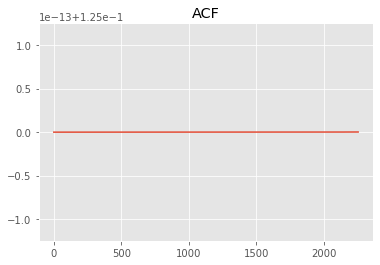

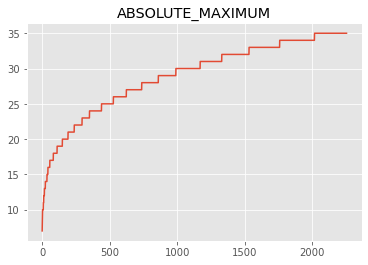

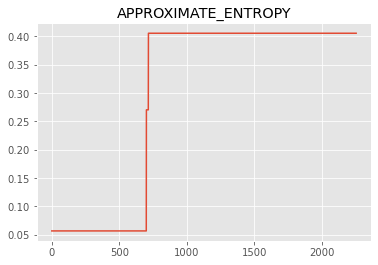

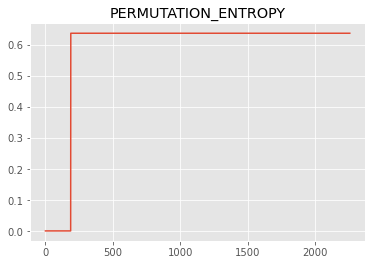

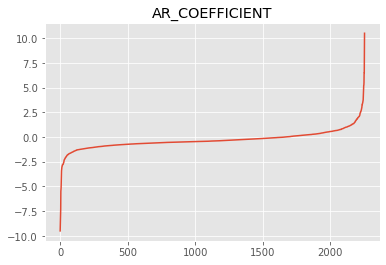

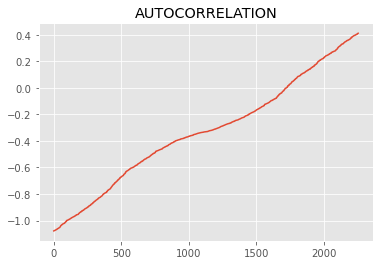

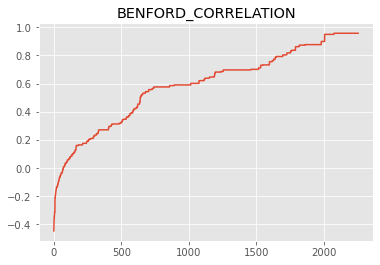

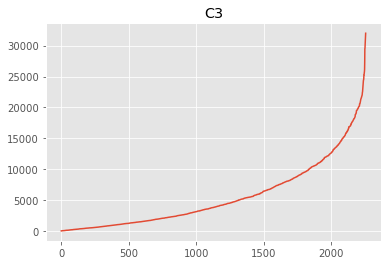

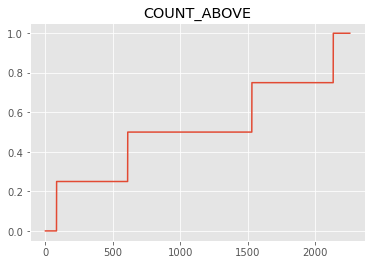

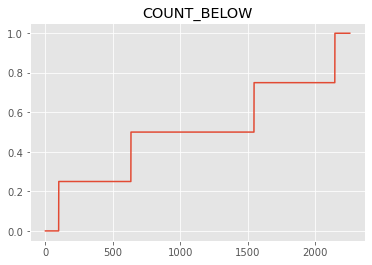

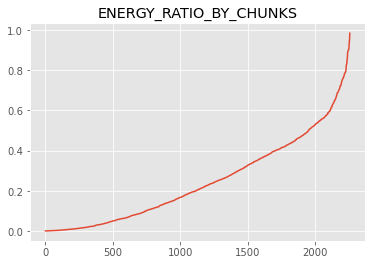

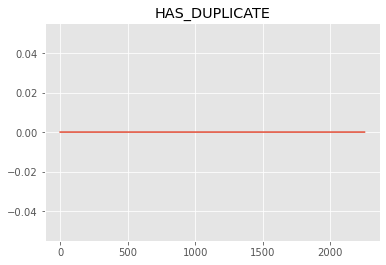

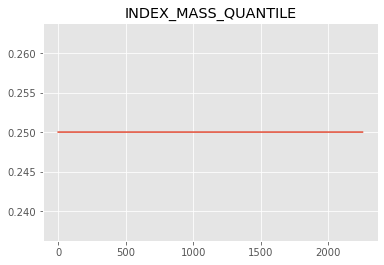

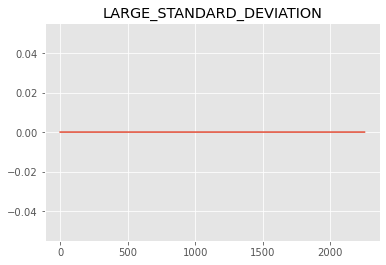

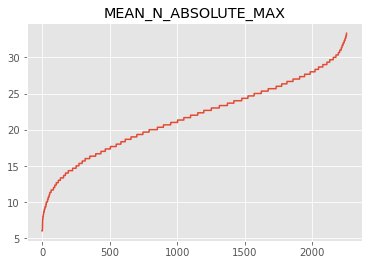

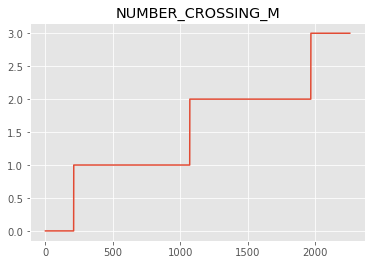

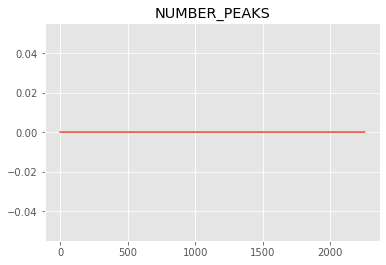

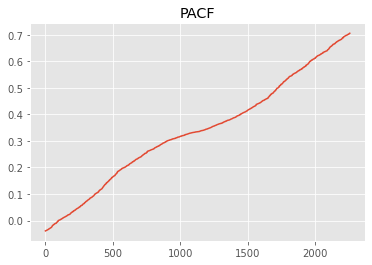

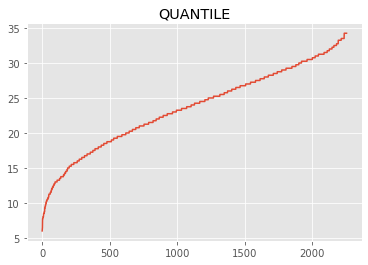

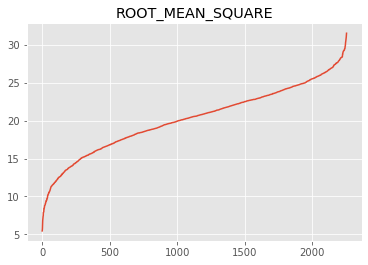

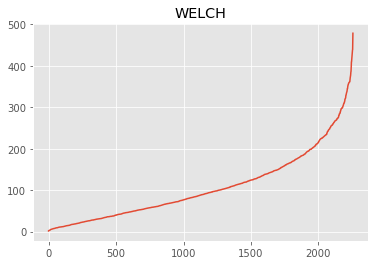

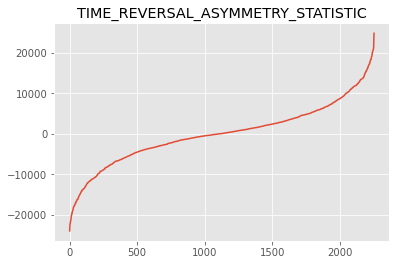

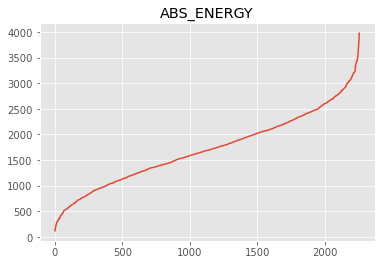

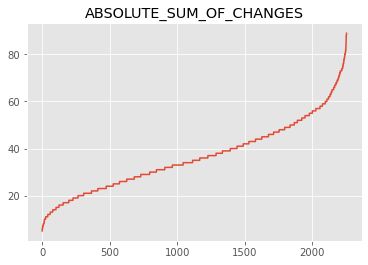

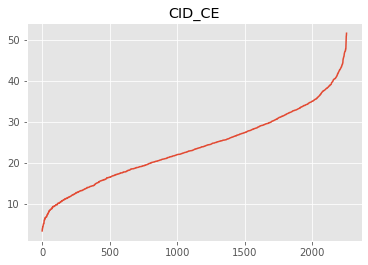

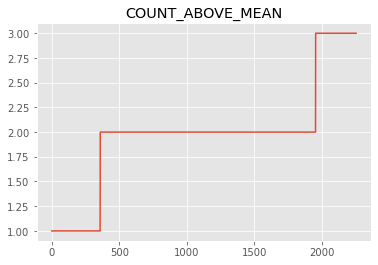

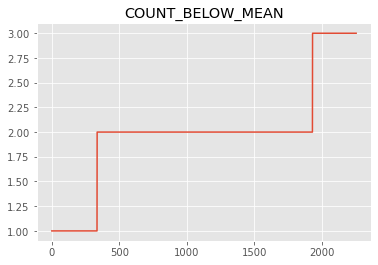

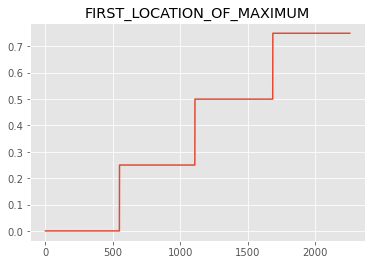

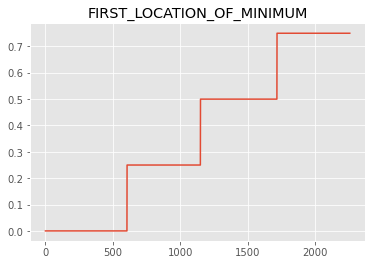

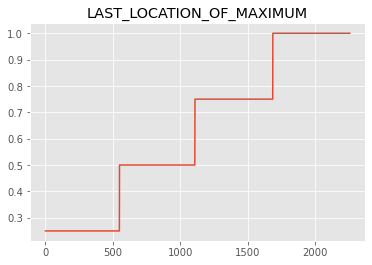

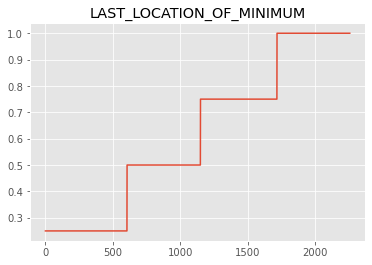

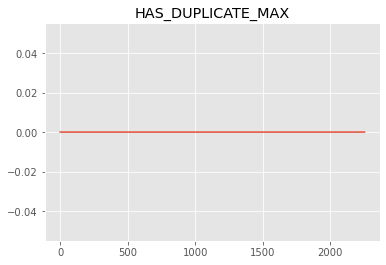

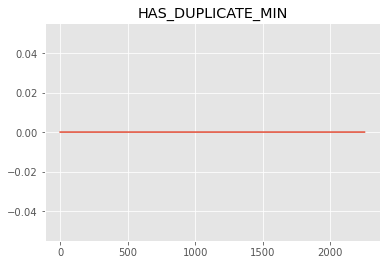

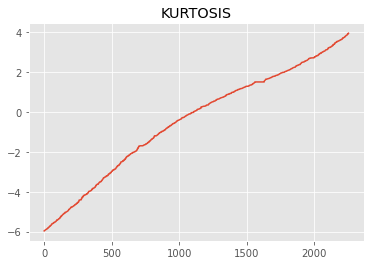

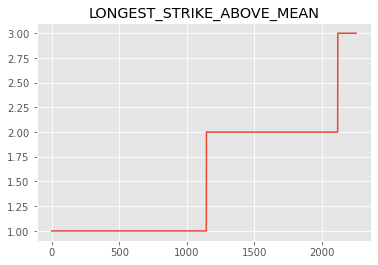

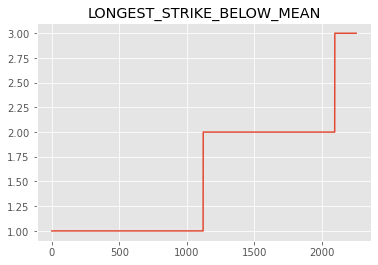

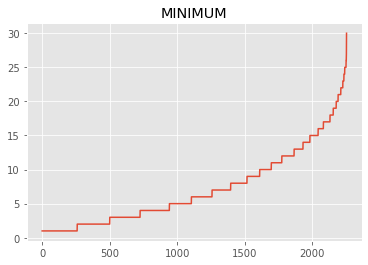

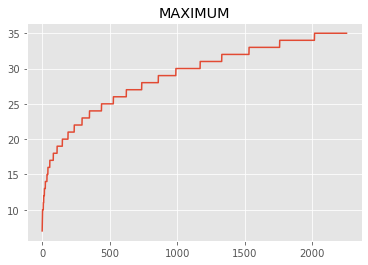

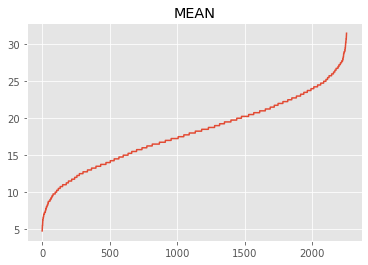

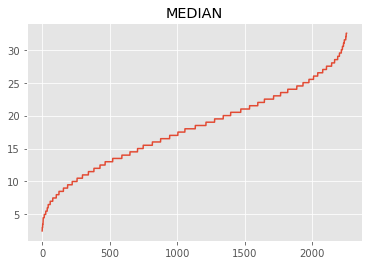

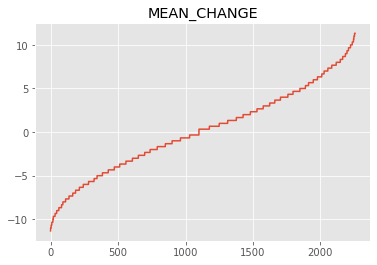

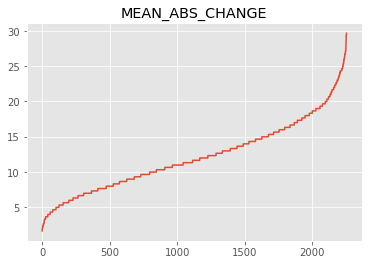

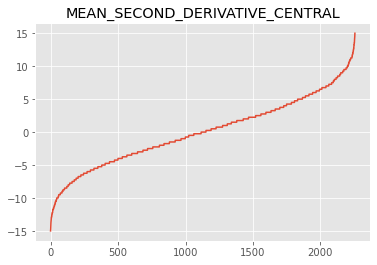

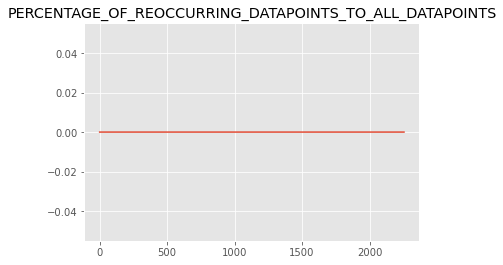

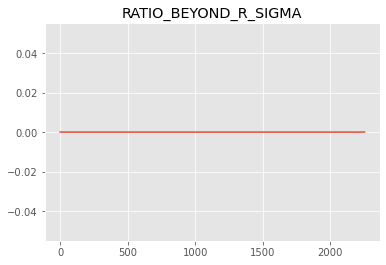

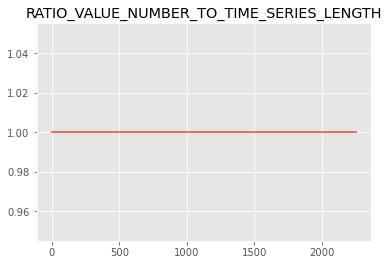

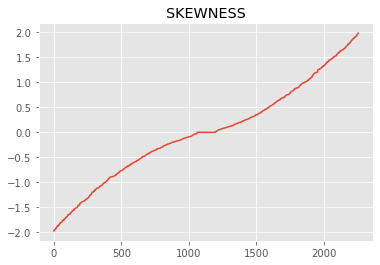

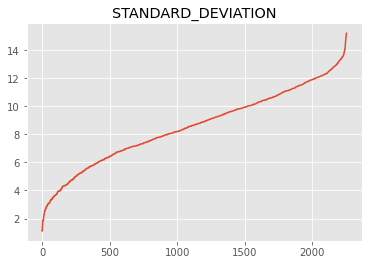

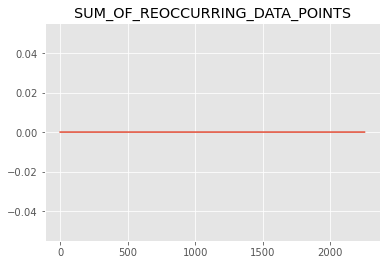

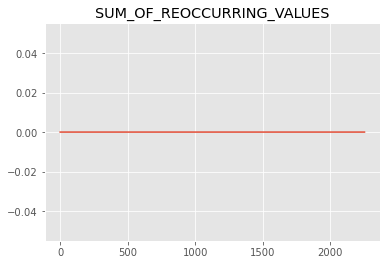

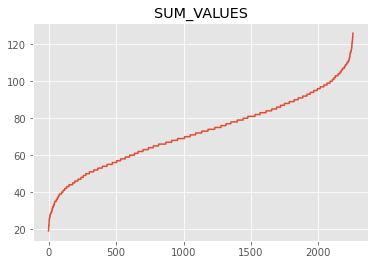

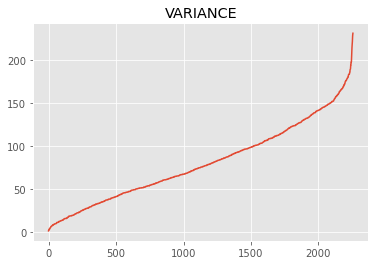

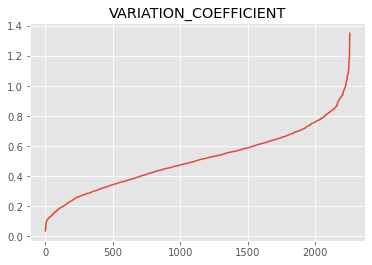

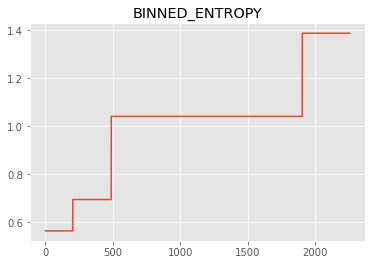

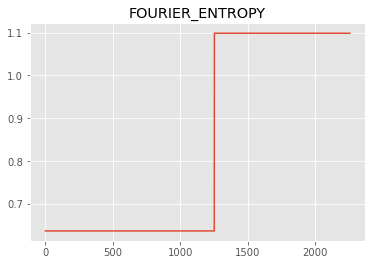

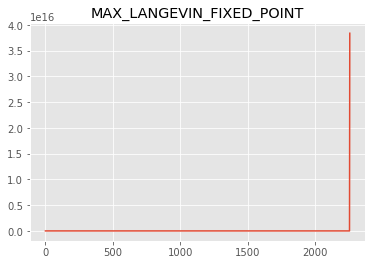

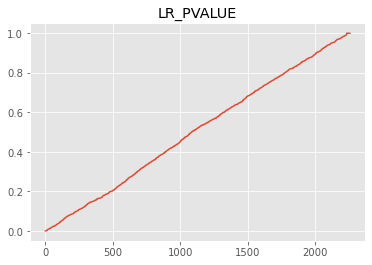

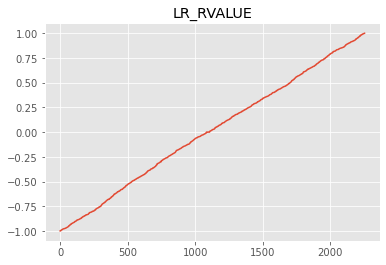

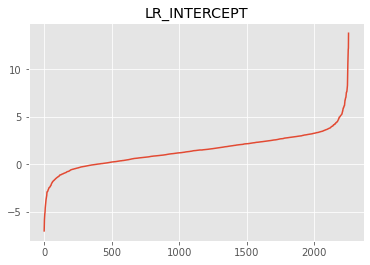

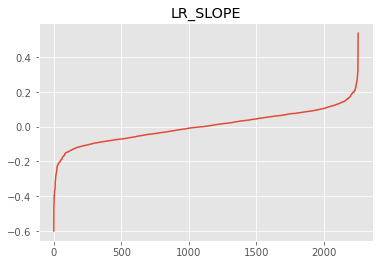

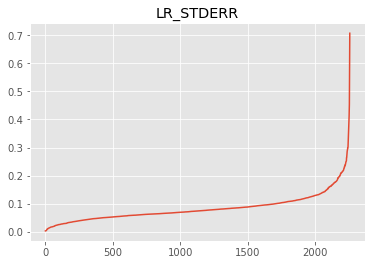

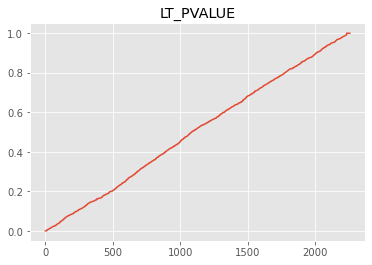

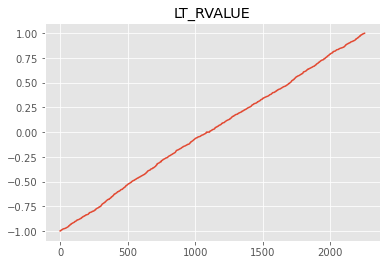

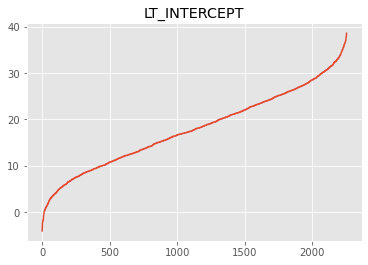

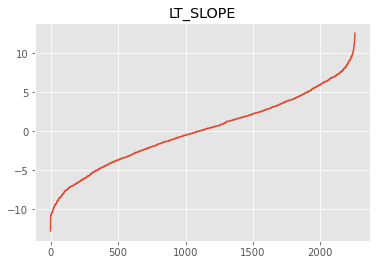

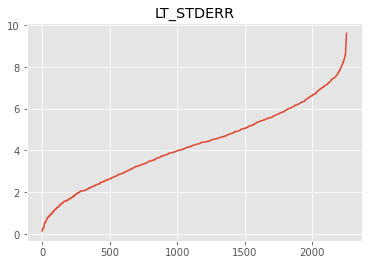

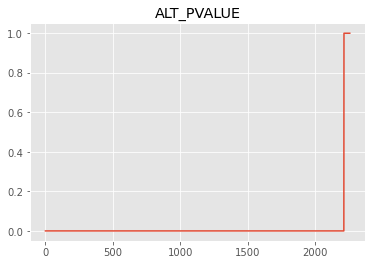

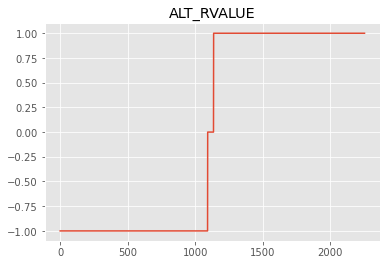

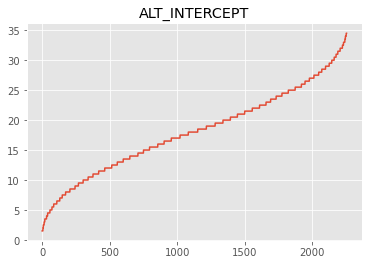

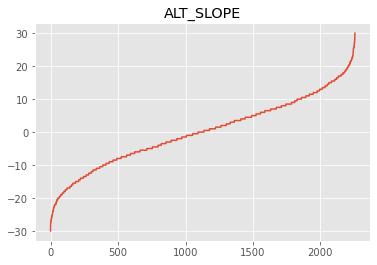

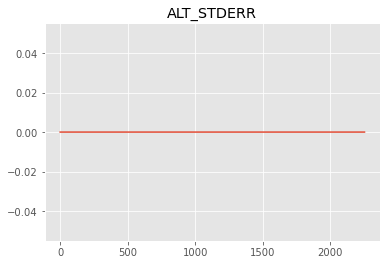

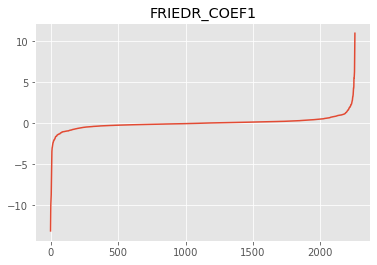

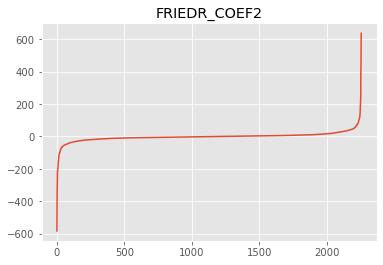

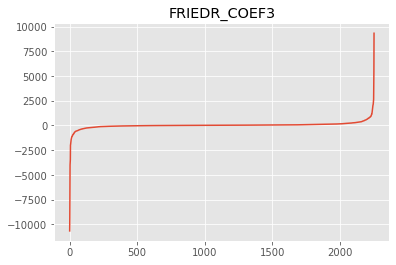

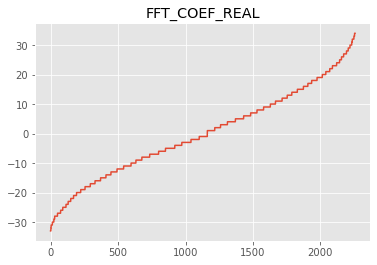

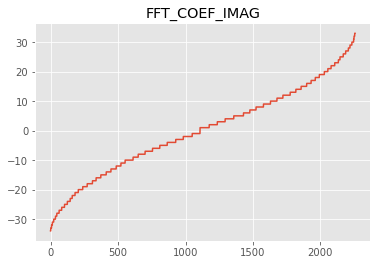

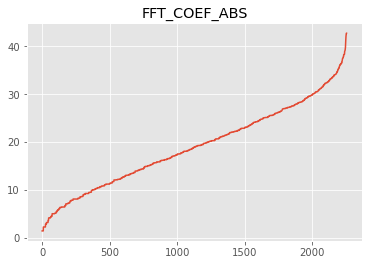

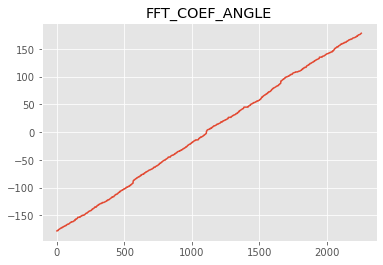

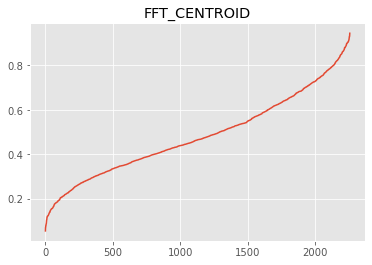

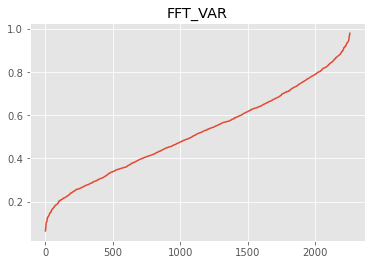

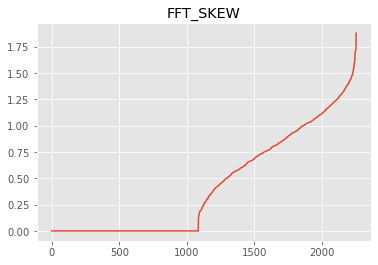

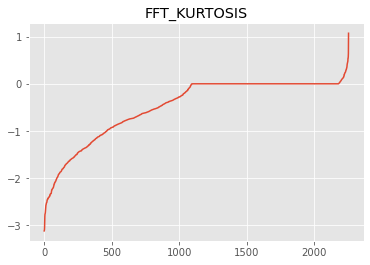

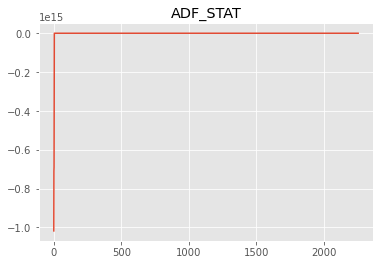

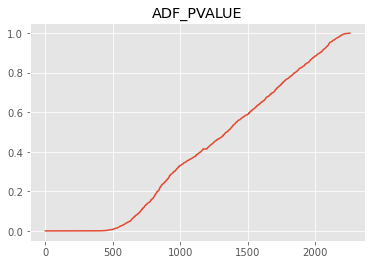

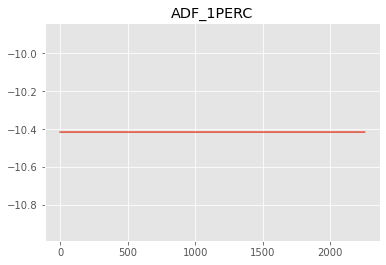

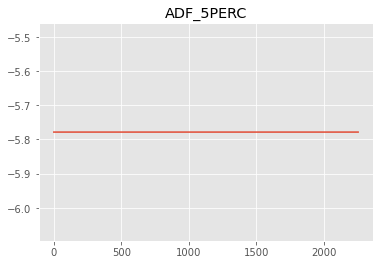

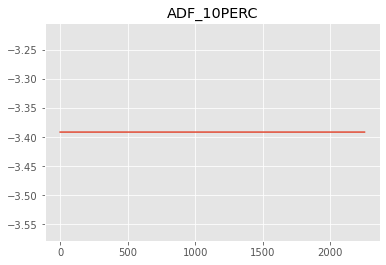

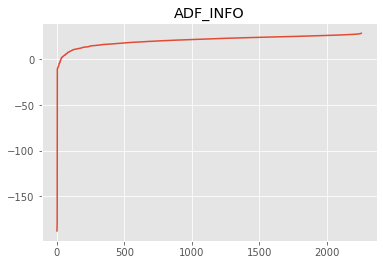

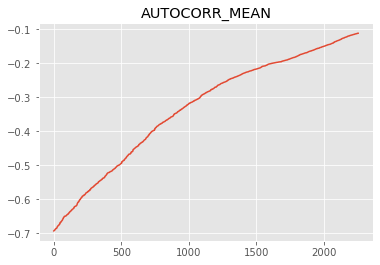

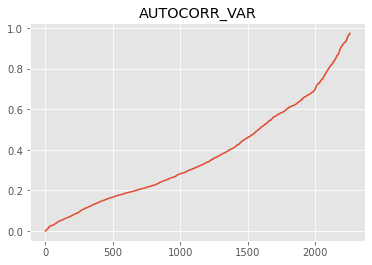

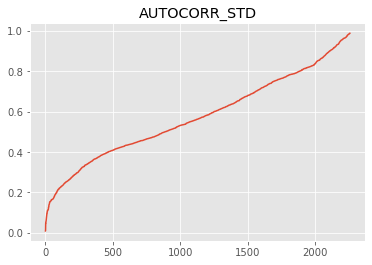

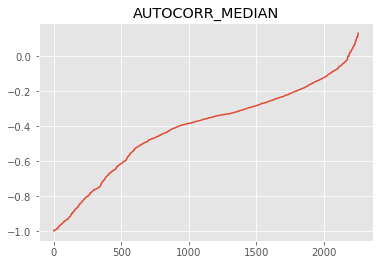

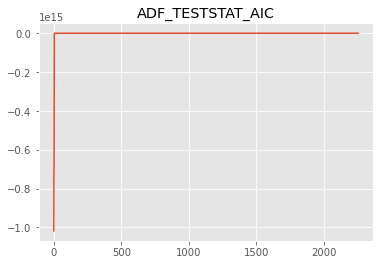

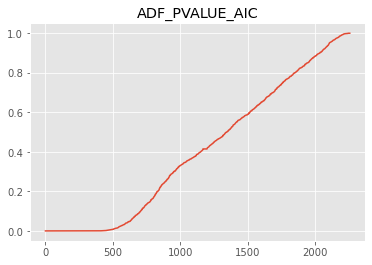

In [51]:
for c in cols:
    plt.plot( sorted(df[c].values) )
    plt.title(c.upper())
    plt.show()

In [66]:
# columns w/same info - leave one, drop the rest
# many of these are due to different cols have the same single value in them (e.g. 0)
dupes = dict()
for c1 in df.columns:
    cols_seen = [ item for sublist in list(dupes.values()) for item in sublist ]
    if c1 not in cols_seen:
        temp = []
        for c2 in df.columns:
            if c1 == c2:
                continue
            if df[c1].equals(df[c2]):
                temp.append(c2)
        if temp:
            dupes[c1] = temp
dupes

{'absolute_maximum': ['maximum'],
 'has_duplicate': ['has_duplicate_max', 'has_duplicate_min'],
 'large_standard_deviation': ['number_peaks',
  'sum_of_reoccurring_data_points',
  'sum_of_reoccurring_values'],
 'percentage_of_reoccurring_datapoints_to_all_datapoints': ['ratio_beyond_r_sigma',
  'alt_stderr'],
 'lr_pvalue': ['lt_pvalue'],
 'lr_rvalue': ['lt_rvalue'],
 'adf_stat': ['adf_teststat_aic'],
 'adf_pvalue': ['adf_pvalue_aic']}

In [19]:
# these columns have flat plots with a single value
cols_2drop = [ 'sample_entropy', 'has_duplicate_max', 'has_duplicate_min',
               'percentage_of_reoccurring_datapoints_to_all_datapoints',
               'ratio_beyond_r_sigma', 'ratio_value_number_to_time_series_length',
               'sum_of_reoccurring_data_points', 'sum_of_reoccurring_values',
               ]
df = df.drop( cols_2drop, axis=1 )

# long names don't fit into plots
cols_2rename = { 'absolute_sum_of_changes': 'abs_change',
                 'count_above_mean': 'count>mean',
                 'count_below_mean': 'count<mean',
                 'first_location_of_maximum': '1st_max_pos',
                 'first_location_of_minimum': '1st_min_pos',
                 'last_location_of_maximum': 'last_max_pos',
                 'last_location_of_minimum': 'last_min_pos',
                 'longest_strike_above_mean': 'longest>mean',
                 'longest_strike_below_mean': 'longest<mean',
                 'mean_second_derivative_central': 'mean_2nd_deriv',
                 'standard_deviation': 'std_dev',
                 'variation_coefficient': 'variation_coef',
               }
df = df.rename( columns = cols_2rename )

## Correlation

In [52]:
# get X and y first (a cell below)
print(len(y))
y = y.tolist()
y.append(np.nan)
print(len(y))
df['target'] = y
df.head()

2255
2256


,Game,Month,Day,Year,Num1,Num2,Num3,Num4,Bonus,abs_energy,abs_change,cid_ce,count>mean,count<mean,1st_max_pos,1st_min_pos,last_max_pos,last_min_pos,kurtosis,longest>mean,longest<mean,minimum,maximum,mean,median,mean_change,mean_abs_change,mean_2nd_deriv,skewness,std_dev,sum_values,variance,variation_coef,target
0,Texas Two Step,5,18,2001,9,10,22,13,1,834,22,15.033296,1,3,0.50,0.00,0.75,0.25,2.228571,1,2,9,22,13.50,11.5,1.333333,7.333333,-2.50,1.545425,5.123475,54,26.2500,0.379517,30.0
1,Texas Two Step,5,22,2001,30,34,23,4,13,2601,34,22.315914,3,1,0.25,0.75,0.50,1.00,1.662867,3,1,4,34,22.75,26.5,-8.666667,11.333333,-5.75,-1.356150,11.519006,91,132.6875,0.506330,3.0
2,Texas Two Step,5,25,2001,3,29,18,33,17,2263,52,31.968735,2,2,0.75,0.00,1.00,0.25,-0.524460,1,1,3,33,20.75,23.5,10.000000,17.333333,-2.75,-0.885232,11.627016,83,135.1875,0.560338,23.0
3,Texas Two Step,5,29,2001,23,35,28,17,20,2827,30,17.720045,2,2,0.25,0.75,0.50,1.00,-0.467940,2,1,17,35,25.75,25.5,-2.000000,10.000000,-5.75,0.168139,6.609652,103,43.6875,0.256686,16.0
4,Texas Two Step,6,1,2001,16,11,28,4,31,1177,46,29.832868,2,2,0.50,0.75,0.75,1.00,0.648514,1,1,4,28,14.75,13.5,-4.000000,15.333333,-4.75,0.666142,8.757140,59,76.6875,0.593704,32.0


<AxesSubplot:>

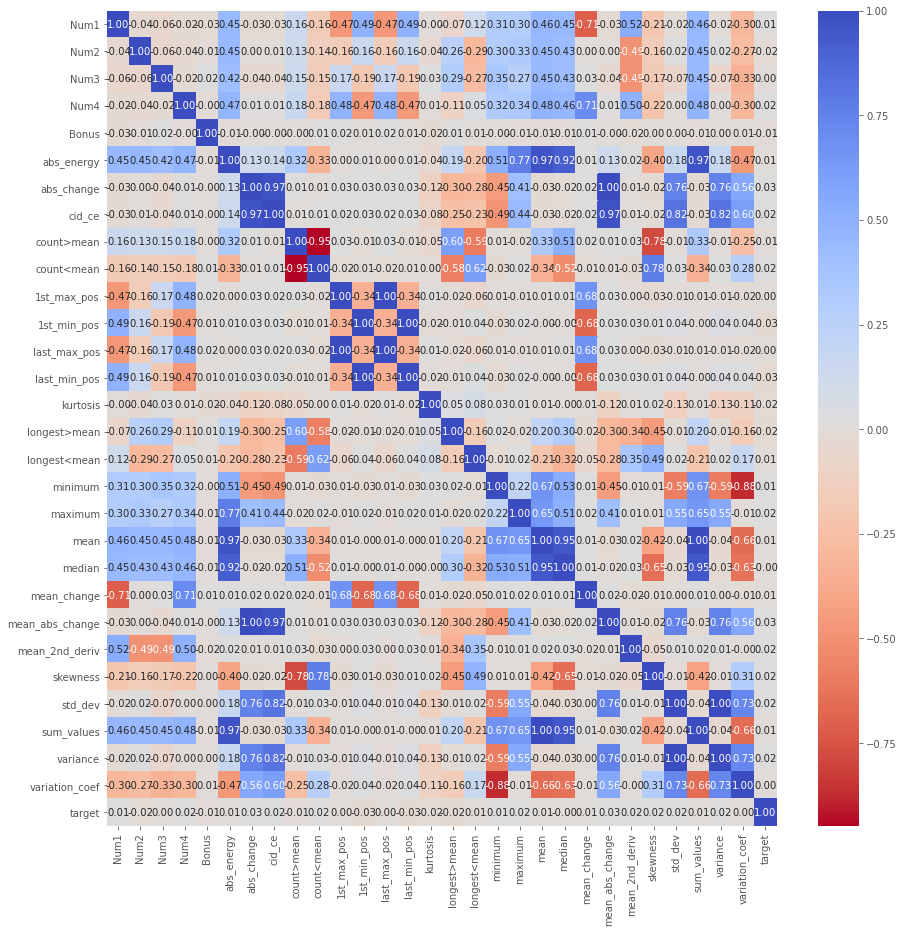

In [54]:
plt.figure(figsize=(15,15))
df_corr = df[ [c for c in df.columns if c not in ['Month', 'Day', 'Year',] ] ]
c = df_corr.corr(method ='spearman')                                #pearson, kendall, spearman
sns.heatmap(c, cmap='coolwarm_r', annot=True, fmt='.2f')

In [28]:
df = df.drop('target', axis=1)

## Regression model

In [29]:
n_steps      = 1
random_state = 34
overlap      = True
flatten      = True
y_pos        = 0

( X,
  y, )  = prepare_data(  df,
                         features,
                         n_steps,
                         overlap=overlap,
                         flatten=flatten,
                         y_pos=y_pos, )
print('Dataframe, X and y shape:', df.shape, X.shape, y.shape)
'''
max_value = max(y)
print(f'Replacing y={max_value} with 0 for use with XGBoost')
y[y==max_value] = 0
max_value = max(y)
print(f'Max value after replacement: {max_value}')
'''

Dataframe, X and y shape: (2256, 33) (2255, 4) (2255,)


"\nmax_value = max(y)\nprint(f'Replacing y={max_value} with 0 for use with XGBoost')\ny[y==max_value] = 0\nmax_value = max(y)\nprint(f'Max value after replacement: {max_value}')\n"

In [30]:
# difference in df.shape[0] and X.shape[0] - last row in df doesn't have y
X, y

(array([[ 9, 10, 22, 13],
        [30, 34, 23,  4],
        [ 3, 29, 18, 33],
        ...,
        [11, 26, 14, 33],
        [19,  4, 33, 26],
        [ 2, 26, 20,  6]]),
 array([30,  3, 23, ..., 19,  2,  8]))

In [31]:
# COUNT LABELS
c = Counter(y)
c.most_common()

[(25, 86),
 (30, 79),
 (4, 75),
 (8, 75),
 (21, 73),
 (22, 73),
 (12, 71),
 (6, 70),
 (9, 70),
 (17, 69),
 (7, 68),
 (34, 68),
 (15, 67),
 (1, 67),
 (10, 67),
 (26, 66),
 (31, 65),
 (35, 64),
 (32, 62),
 (11, 62),
 (2, 62),
 (19, 62),
 (3, 61),
 (20, 61),
 (33, 60),
 (18, 60),
 (13, 60),
 (23, 59),
 (5, 59),
 (29, 58),
 (16, 57),
 (27, 57),
 (24, 49),
 (28, 47),
 (14, 46)]

## Visualize y

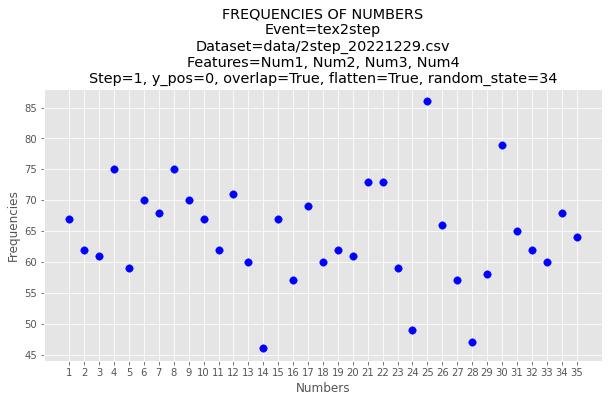

In [32]:
# PLOT LABEL FREQUENCIES
x_ = list(c.keys())
y_ = list(c.values())
title = f"FREQUENCIES OF NUMBERS\nEvent={event}\nDataset={file}\nFeatures={', '.join(features)}\n" +\
        f'Step={n_steps}, y_pos={y_pos}, overlap={overlap}, flatten={flatten}, random_state={random_state}'

plt.figure(figsize=(10, 5))
plt.scatter(x_, y_, c='blue', s=55)
plt.xticks(x_)
plt.title(title)
plt.xlabel('Numbers')
plt.ylabel('Frequencies')
#plt.tight_layout()
plt.show()

__Outliers: 14, 24, 25, 28, 30__

/Users/andrew.nedilko/opt/anaconda3/envs/iq/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


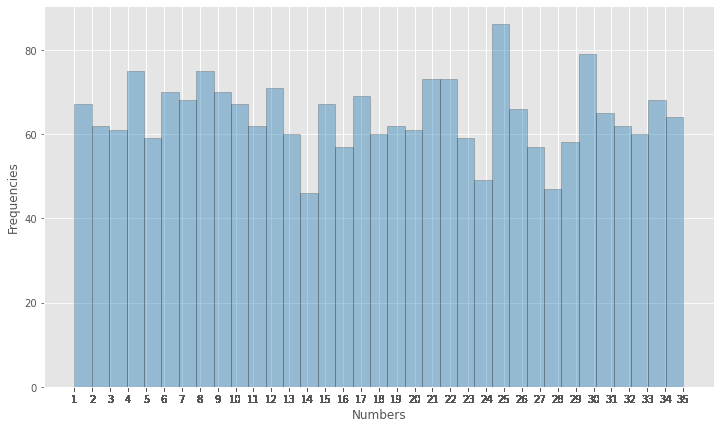

In [33]:
plt.figure(figsize=(12, 7))
sns.distplot( y, hist=True, kde=False,
              bins=35, color='tab:blue',
              hist_kws={'edgecolor':'black'},
              kde_kws={'linewidth':4}
            )
plt.xticks(y)
plt.xlabel('Numbers')
plt.ylabel('Frequencies')
plt.show()

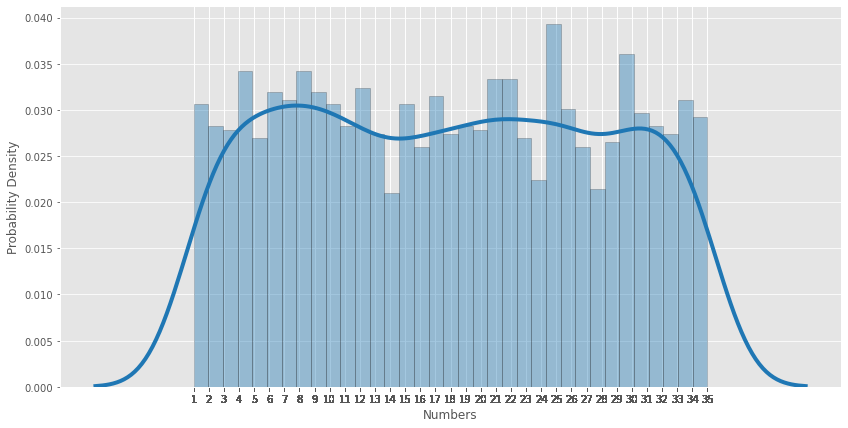

In [34]:
plt.figure(figsize=(14, 7))
sns.distplot( y, hist=True, kde=True,
              bins=35, color='tab:blue',
              hist_kws={'edgecolor':'black'},
              kde_kws={'linewidth':4}
            )
plt.xticks(y)
plt.xlabel('Numbers')
plt.ylabel('Probability Density')
plt.show()

In [35]:
test_size=0.2

# stratified implemented only if shuffle=True
X_sh, y_sh = deepcopy(X), deepcopy(y)
X_train_sh, X_test_sh, y_train_sh, y_test_sh = train_test_split( X_sh, y_sh,
                                                                 test_size=test_size,
                                                                 random_state=random_state,
                                                                 shuffle=True,
                                                                 #stratify=y,
                                                               )

# not stratified - time series
X_train, X_test, y_train, y_test = train_test_seq_split(X, y, test_size=test_size)

In [41]:
regr_params_xgb = {
    'n_estimators': 100,
    'max_depth': None,                                # default 6
    'learning_rate': 0.3,                             # eta, default 0.3
    'objective': 'reg:squarederror',                  # reg:squarederror, reg:squaredlogerror, reg:pseudohubererror, reg:tweedie, reg:gamma           
    'eval_metric': 'rmse',                            # 'rmse', 'rmsle', 'mae', 'mape', 'mphe' (huber), 'logloss',
                                                      # OR 'eval_metric': mean_absolute_error, import sklearn metric, then reg.fit(X, y, eval_set=[(X, y)])
    #'early_stopping_rounds': 5,                      # requires eval_set
    'max_leaves': 0,                                  # max # leaves; default 0 - no limit
    'grow_policy': 'depthwise',                       # default 'depthwise', 'lossguide'
    'process_type': 'default',                        # 'default', 'update' for boosting
    'num_parallel_tree': 1,                           # default 1, num parallel trees built in each iteration
    'base_score': 0.5,
    'booster': 'gbtree',                              # gbtree, dart, gblinear?
    'tree_method': 'auto',                            # auto, exact, approx, hist and gpu_hist
    'importance_type': 'weight',                      # default“gain”,“weight”,“cover”,“total_gain”,“total_cover”
    'gamma': 0,                                       # larger - more conservative, [0, inf], default 0
    'reg_alpha': 0,                                   # L1 reg., larger - more conservative, default 0 (0.1)
    'reg_lambda': 1,                                  # L2 rreg., larger - more conservative, default 1 (0.3)
    'sampling_method': 'uniform',                     # uniform, gradient_based
    'max_delta_step': 1,                              # 1-10 or 0 for no constraint
    'min_child_weight': 1,
    'subsample': 1,                                   # 0-1  (lower values prevent overfitting), default 1
    'colsample_bylevel': 1,                           # 0-1, default 1
    'colsample_bynode': 1,                            # optimized for higher recall, default 1
    'colsample_bytree': 1,                            # 0-1, default 1
    'seed': 5,
    'random_state': random_state,
    'n_jobs': -1,
    #'callbacks':,    # e.g. xgboost.callback.EarlyStopping
}

## Time Series Split (No Shuffling)

In [42]:
# FIT & TEST
regr = XGBRegressor( **regr_params_xgb )
regr.fit( X_train, y_train )
y_pred = regr.predict( X_test )

# PRINT RESULTS
print( strftime("%Y-%m-%d %H:%M:%S", localtime()) )
print(f'Event: {event}\nDataset: {file}\nTrain-test split: time series\nSteps: {n_steps}  |  Y_pos: {y_pos}  |  Random state: {random_state}')
print(f'Features: {features}\nOverlap: {overlap}  |  Flatten: {flatten}\n')

rmse = math.sqrt(mean_squared_error(y_test, y_pred))
mae  = mean_absolute_error(y_test, y_pred)
r2   = r2_score(y_test, y_pred)

print(f'RMSE = {round(rmse, 4)}')
print(f'MAE  = {round(mae, 4)}')
print(f'R2   = {round(r2, 4)}')

2023-01-01 03:57:46
Event: tex2step
Dataset: data/2step_20221229.csv
Train-test split: time series
Steps: 1  |  Y_pos: 0  |  Random state: 34
Features: ['Num1', 'Num2', 'Num3', 'Num4']
Overlap: True  |  Flatten: True

RMSE = 10.7634
MAE  = 9.1426
R2   = -0.1094


In [43]:
for i, j in zip(y_test, y_pred):
    print(f'{i}:  {j}')

25:  19.694393157958984
21:  18.316547393798828
35:  18.962421417236328
17:  17.31723976135254
12:  19.097787857055664
31:  18.700197219848633
22:  13.57491397857666
4:  20.164335250854492
16:  15.714207649230957
17:  11.70119857788086
30:  21.069225311279297
19:  16.556297302246094
26:  15.279740333557129
16:  20.233564376831055
13:  15.119416236877441
10:  19.12295913696289
12:  20.41058921813965
15:  16.99336814880371
26:  18.788782119750977
34:  22.66939926147461
33:  18.203134536743164
17:  16.53713035583496
7:  17.601560592651367
32:  21.27821159362793
12:  18.933183670043945
11:  15.519179344177246
34:  18.026092529296875
15:  14.660256385803223
7:  20.47277069091797
19:  19.9088191986084
7:  15.122337341308594
23:  13.97126293182373
33:  20.535888671875
17:  17.003137588500977
8:  14.329340934753418
15:  17.443819046020508
14:  22.00177001953125
21:  17.623287200927734
21:  18.914737701416016
16:  18.803560256958008
32:  20.003856658935547
20:  16.37051773071289
20:  21.2669258

## Stratified Split (With Shuffling)

In [44]:
# FIT & TEST
regr_sh = XGBRegressor( **regr_params_xgb )
regr_sh.fit( X_train_sh, y_train_sh )
y_pred_sh = regr_sh.predict( X_test_sh )

# PRINT RESULTS
print( strftime("%Y-%m-%d %H:%M:%S", localtime()) )
print(f'Event: {event}\nDataset: {file}\nTrain-test split: stratified w/shuffling\nSteps: {n_steps}  |  Y_pos: {y_pos}  |  Random state: {random_state}')
print(f'Features: {features}\nOverlap: {overlap}  |  Flatten: {flatten}\n')

rmse_sh = math.sqrt(mean_squared_error(y_test_sh, y_pred_sh))
mae_sh  = mean_absolute_error(y_test_sh, y_pred_sh)
r2_sh   = r2_score(y_test_sh, y_pred_sh)

print(f'RMSE = {round(rmse_sh, 4)}')
print(f'MAE  = {round(mae_sh, 4)}')
print(f'R2   = {round(r2_sh, 4)}')

2023-01-01 03:58:04
Event: tex2step
Dataset: data/2step_20221229.csv
Train-test split: stratified w/shuffling
Steps: 1  |  Y_pos: 0  |  Random state: 34
Features: ['Num1', 'Num2', 'Num3', 'Num4']
Overlap: True  |  Flatten: True

RMSE = 10.9454
MAE  = 9.4965
R2   = -0.1089


In [45]:
for i, j in zip(y_test_sh, y_pred_sh):
    print(f'{i}:  {j}')

32:  20.10968017578125
34:  13.78969955444336
25:  17.622182846069336
29:  17.190767288208008
34:  20.671358108520508
6:  20.4464168548584
1:  16.72334098815918
31:  21.115798950195312
1:  18.9257869720459
18:  17.44441795349121
18:  19.39316177368164
24:  22.192337036132812
21:  16.015504837036133
21:  10.920755386352539
10:  14.365970611572266
31:  15.8853178024292
8:  20.25545310974121
29:  16.320465087890625
23:  18.90462875366211
10:  14.960617065429688
35:  18.502172470092773
25:  11.518922805786133
4:  18.050580978393555
12:  14.371309280395508
2:  16.128263473510742
35:  19.016918182373047
28:  14.467596054077148
27:  15.151549339294434
33:  21.38994598388672
7:  13.412768363952637
19:  19.31437110900879
13:  19.927339553833008
5:  24.917877197265625
30:  18.658008575439453
25:  9.970219612121582
26:  20.2490177154541
16:  13.5615873336792
23:  19.679685592651367
26:  11.423748970031738
16:  16.58296012878418
33:  18.11465072631836
11:  11.990988731384277
21:  15.74578475952148

In [ ]:
unknown_variable

# Part 2. Parameter Search Loop

In [228]:
random_state = 34
n_steps      = 12
overlap      = True
flatten      = True
y_pos        = 0

keys         = ['value', 'rmse', 'mae', 'r2', 'rmse_sh', 'mae_sh', 'r2_sh', ]
res          = []
value_name   = 'colsample_bytree'

for value in range(0, 101, 5):
        
    modified_value = value/100
        
    # PREPARE DATA
    ( X,
      y, )  = prepare_data(  df,
                             features,
                             n_steps,
                             overlap=overlap,
                             flatten=flatten,
                             y_pos=y_pos, )
    #print('X and y shape:', X.shape, y.shape)
    
    # TRAIN-TEST SPLIT
    test_size=0.2

    # stratified implemented only if shuffle=True
    X_sh, y_sh = deepcopy(X), deepcopy(y)
    X_train_sh, X_test_sh, y_train_sh, y_test_sh = train_test_split( X_sh, y_sh,
                                                                     test_size=test_size,
                                                                     random_state=random_state,
                                                                     shuffle=True,
                                                                     stratify=y )

    # not stratified - time series
    X_train, X_test, y_train, y_test = train_test_seq_split(X, y, test_size=test_size)
        
    
    # REGRESSOR
    regr_params_xgb = {
        'n_estimators': 100,
        'max_depth': None,                                # default 6
        'learning_rate': 0.2,                             # eta, default 0.3
        'objective': 'reg:squarederror',                  # reg:squarederror, reg:squaredlogerror, reg:pseudohubererror, reg:tweedie, reg:gamma           
        'eval_metric': 'rmse',                            # 'rmse', 'rmsle', 'mae', 'mape', 'mphe' (huber), 'logloss',
                                                          # OR 'eval_metric': mean_absolute_error, import sklearn metric, then reg.fit(X, y, eval_set=[(X, y)])
        #'early_stopping_rounds': 5,                      # requires eval_set
        'max_leaves': 0,                                  # max # leaves; default 0 - no limit
        'grow_policy': 'depthwise',                       # default 'depthwise', 'lossguide'
        'process_type': 'default',                        # 'default', 'update' for boosting
        'num_parallel_tree': 1,                           # default 1, num parallel trees built in each iteration
        'base_score': 0.5,
        'booster': 'gbtree',                              # gbtree, dart, gblinear?
        'tree_method': 'auto',                            # auto, exact, approx, hist and gpu_hist
        'importance_type': 'weight',                      # default“gain”,“weight”,“cover”,“total_gain”,“total_cover”
        'gamma': 0.4,                                     # larger - more conservative, [0, inf], default 0
        'reg_alpha': 0.9,                                 # L1 reg., larger - more conservative, default 0 (0.1)
        'reg_lambda': 8,                                  # L2 rreg., larger - more conservative, default 1 (0.3)
        'sampling_method': 'uniform',                     # uniform, gradient_based
        'max_delta_step': 0,                              # 1-10 or 0 for no constraint
        'min_child_weight': 1,
        'subsample': 0.7,                                 # 0-1  (lower values prevent overfitting), default 1
        'colsample_bylevel': 0,                           # 0-1, default 1
        'colsample_bynode': 1,                            # optimized for higher recall, default 1
        'colsample_bytree': 1,                            # 0-1, default 1
        'seed': 5,
        'random_state': random_state,
        'n_jobs': -1,
        #'callbacks':,    # e.g. xgboost.callback.EarlyStopping
    }    
    
    # TRAIN ON TIME SERIES SPLIT (NO SHUFFLING)
    regr = XGBRegressor( **regr_params_xgb )
    regr.fit( X_train, y_train )
    y_pred = regr.predict( X_test )

    print( strftime("%Y-%m-%d %H:%M:%S", localtime()) )
    print(f'Event: {event}\nTrain-test split: time series\nSteps: {n_steps}  |  Y_pos: {y_pos}  |  Random state: {random_state}')
    print(f'Features: {features}\nOverlap: {overlap}  |  Flatten: {flatten}')
    print(f'{value_name}: {modified_value}\n')

    rmse = math.sqrt(mean_squared_error(y_test, y_pred))
    mae  = mean_absolute_error(y_test, y_pred)
    r2   = r2_score(y_test, y_pred)

    print(f'RMSE = {round(rmse, 4)}')
    print(f'MAE  = {round(mae, 4)}')
    print(f'R2   = {round(r2, 4)}')
    print('\n', '+'*100, '\n', sep='')    
    
    
    # TRAIN ON STRATIFIED SPLIT (WITH SHUFFLING)
    regr_sh = XGBRegressor( **regr_params_xgb )
    regr_sh.fit( X_train_sh, y_train_sh )
    y_pred_sh = regr_sh.predict( X_test_sh )

    print( strftime("%Y-%m-%d %H:%M:%S", localtime()) )
    print(f'Event: {event}\nTrain-test split: stratified w/shuffling\nSteps: {n_steps}  |  Y_pos: {y_pos}  |  Random state: {random_state}')
    print(f'Features: {features}\nOverlap: {overlap}  |  Flatten: {flatten}')
    print(f'{value_name}: {modified_value}\n')

    rmse_sh = math.sqrt(mean_squared_error(y_test_sh, y_pred_sh))
    mae_sh  = mean_absolute_error(y_test_sh, y_pred_sh)
    r2_sh   = r2_score(y_test_sh, y_pred_sh)

    print(f'RMSE = {round(rmse_sh, 4)}')
    print(f'MAE  = {round(mae_sh, 4)}')
    print(f'R2   = {round(r2_sh, 4)}')
    print('\n\n', '='*100, '\n\n', sep='')    
    
    res.append(( modified_value, rmse, mae, r2, rmse_sh, mae_sh, r2_sh, ))

2022-08-16 09:52:12
Event: texas2step
Train-test split: time series
Steps: 12  |  Y_pos: 0  |  Random state: 34
Features: ['Num1', 'Num2', 'Num3', 'Num4']
Overlap: True  |  Flatten: True
colsample_bytree: 0.0

RMSE = 10.6139
MAE  = 9.0303
R2   = -0.0804

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

2022-08-16 09:52:12
Event: texas2step
Train-test split: stratified w/shuffling
Steps: 12  |  Y_pos: 0  |  Random state: 34
Features: ['Num1', 'Num2', 'Num3', 'Num4']
Overlap: True  |  Flatten: True
colsample_bytree: 0.0

RMSE = 10.558
MAE  = 9.1272
R2   = -0.081




2022-08-16 09:52:14
Event: texas2step
Train-test split: time series
Steps: 12  |  Y_pos: 0  |  Random state: 34
Features: ['Num1', 'Num2', 'Num3', 'Num4']
Overlap: True  |  Flatten: True
colsample_bytree: 0.05

RMSE = 10.9633
MAE  = 9.275
R2   = -0.1527

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

2022-08-16 09:52:14

2022-08-16 09:52:37
Event: texas2step
Train-test split: time series
Steps: 12  |  Y_pos: 0  |  Random state: 34
Features: ['Num1', 'Num2', 'Num3', 'Num4']
Overlap: True  |  Flatten: True
colsample_bytree: 0.6

RMSE = 10.8003
MAE  = 9.1578
R2   = -0.1187

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

2022-08-16 09:52:37
Event: texas2step
Train-test split: stratified w/shuffling
Steps: 12  |  Y_pos: 0  |  Random state: 34
Features: ['Num1', 'Num2', 'Num3', 'Num4']
Overlap: True  |  Flatten: True
colsample_bytree: 0.6

RMSE = 10.5706
MAE  = 8.9734
R2   = -0.0836




2022-08-16 09:52:39
Event: texas2step
Train-test split: time series
Steps: 12  |  Y_pos: 0  |  Random state: 34
Features: ['Num1', 'Num2', 'Num3', 'Num4']
Overlap: True  |  Flatten: True
colsample_bytree: 0.65

RMSE = 10.8438
MAE  = 9.2502
R2   = -0.1277

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

2022-08-16 09:52

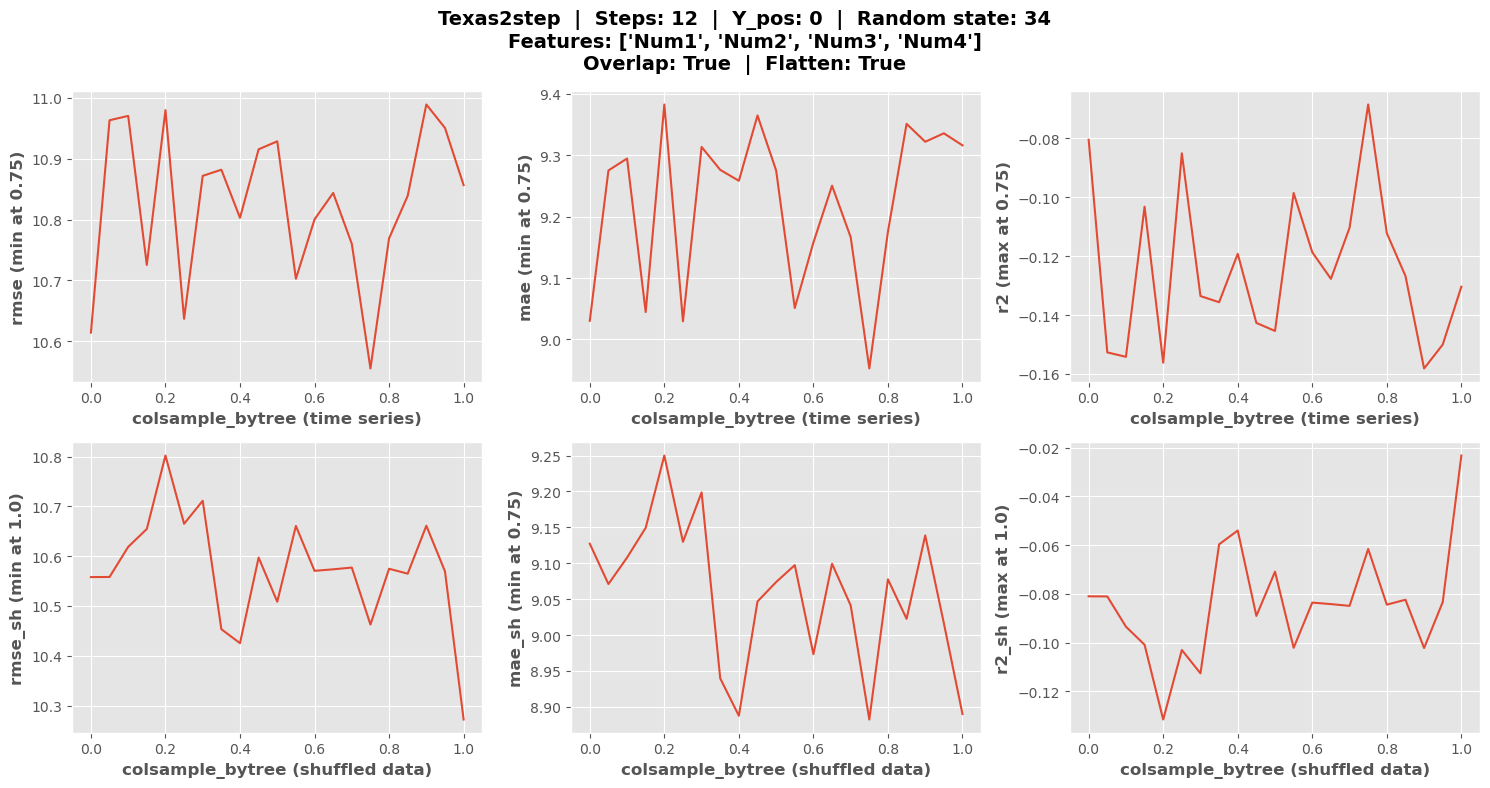

In [229]:
def plot_new(ax, a, b, xlabel, ylabel):
    ax.plot(a, b)
    ax.set_xlabel(xlabel, fontweight='bold')
    ax.set_ylabel(ylabel, fontweight='bold')
        
    
plt.rcParams.update({'figure.figsize':(15,8)})    
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(nrows=2, ncols=3)
axes = [0, ax1, ax2, ax3, ax4, ax5, ax6]
for idx in range(1,7):
    a = [i[0] for i in res] 
    b = [i[idx] for i in res]
    mode = 'shuffled data' if '_sh' in keys[idx] else 'time series'
    xlabel = f'{value_name} ({mode})'
        
    if not 'r2' in keys[idx]:
        min_b   = min(b)
        min_idx = b.index(min_b)        
        ylabel  = f'{keys[idx]} (min at {a[min_idx]})'
    else:
        max_b   = max(b)
        max_idx = b.index(max_b)
        ylabel  = f'{keys[idx]} (max at {a[max_idx]})'
        
    plot_new(axes[idx], a, b, xlabel, ylabel)

suptitle = f'{event.capitalize()}  |  Steps: {n_steps}  |  Y_pos: {y_pos}  |  Random state: {random_state}\n'
suptitle += f'Features: {features}\nOverlap: {overlap}  |  Flatten: {flatten}'
plt.suptitle(suptitle, fontsize=14, fontweight='bold')
plt.tight_layout()

# Part 3. Other Regressors
Best OOTB results -

In [14]:
from sklearn.linear_model import LinearRegression, ElasticNet, BayesianRidge, Lasso, SGDRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
#from lightgbm import LGBMRegressor
from sklearn.kernel_ridge import KernelRidge
from catboost import CatBoostRegressor

In [ ]:
clf_params = {
}

In [15]:
# FIT & TEST
regr = Lasso()
regr.fit( X_train, y_train )
y_pred = regr.predict( X_test )

# PRINT RESULTS
print( strftime("%Y-%m-%d %H:%M:%S", localtime()) )
print(f'Event: {event}\nTrain-test split: time series\nSteps: {n_steps}  |  Y_pos: {y_pos}  |  Random state: {random_state}')
print(f'Features: {features}\nOverlap: {overlap}  |  Flatten: {flatten}\n')

rmse = math.sqrt(mean_squared_error(y_test, y_pred))
mae  = mean_absolute_error(y_test, y_pred)
r2   = r2_score(y_test, y_pred)

print(f'RMSE = {round(rmse, 4)}')
print(f'MAE  = {round(mae, 4)}')
print(f'R2   = {round(r2, 4)}')
print('\n', '+'*100, '\n', sep='')


# FIT & TEST
regr_sh = Lasso()
regr_sh.fit( X_train_sh, y_train_sh )
y_pred_sh = regr_sh.predict( X_test_sh )

# PRINT RESULTS
print( strftime("%Y-%m-%d %H:%M:%S", localtime()) )
print(f'Event: {event}\nTrain-test split: stratified w/shuffling\nSteps: {n_steps}  |  Y_pos: {y_pos}  |  Random state: {random_state}')
print(f'Features: {features}\nOverlap: {overlap}  |  Flatten: {flatten}\n')

rmse_sh = math.sqrt(mean_squared_error(y_test_sh, y_pred_sh))
mae_sh  = mean_absolute_error(y_test_sh, y_pred_sh)
r2_sh   = r2_score(y_test_sh, y_pred_sh)

print(f'RMSE = {round(rmse_sh, 4)}')
print(f'MAE  = {round(mae_sh, 4)}')
print(f'R2   = {round(r2_sh, 4)}')

2022-12-30 01:22:36
Event: tex2step
Train-test split: time series
Steps: 1  |  Y_pos: 0  |  Random state: 34
Features: ['Num1', 'Num2', 'Num3', 'Num4']
Overlap: True  |  Flatten: True

RMSE = 10.2429
MAE  = 8.8406
R2   = -0.0047

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

2022-12-30 01:22:36
Event: tex2step
Train-test split: stratified w/shuffling
Steps: 1  |  Y_pos: 0  |  Random state: 34
Features: ['Num1', 'Num2', 'Num3', 'Num4']
Overlap: True  |  Flatten: True

RMSE = 10.4462
MAE  = 9.1578
R2   = -0.01


## Appendix

### Trial of the new feature generation package

In [ ]:
t = [0,1,2,3,4,5,6,7,8,9]

In [ ]:
print(fc.abs_energy(t))
print(fc.absolute_sum_of_changes(t))
print(fc.cid_ce(t, normalize=False))
print(fc.count_above_mean(t))
print(fc.count_below_mean(t))
print(fc.first_location_of_maximum(t))
print(fc.first_location_of_minimum(t))
print(fc.last_location_of_maximum(t))
print(fc.last_location_of_minimum(t))
print(fc.has_duplicate_max(t))
print(fc.has_duplicate_min(t))

In [ ]:
print(fc.kurtosis(t))
print(fc.longest_strike_above_mean(t))
print(fc.longest_strike_below_mean(t))
print(fc.minimum(t))
print(fc.maximum(t))
print(fc.mean(t))
print(fc.median(t))
print(fc.mean_change(t))
print(fc.mean_abs_change(t))
print(fc.mean_second_derivative_central(t))

In [ ]:
print(fc.percentage_of_reoccurring_datapoints_to_all_datapoints(t))
print(fc.ratio_beyond_r_sigma(t, 2))
print(fc.ratio_value_number_to_time_series_length(t))
print(fc.sample_entropy(t))
print(fc.skewness(t))
print(fc.standard_deviation(t))
print(fc.sum_of_reoccurring_data_points(t))
print(fc.sum_of_reoccurring_values(t))
print(fc.sum_values(t))
print(fc.variance(t))
print(fc.variation_coefficient(t))

## Best model params for the four original features

In [ ]:
regr_params_xgb = {
    'n_estimators': 100,
    'max_depth': None,                                # default 6
    'learning_rate': 0.2,                             # eta, default 0.3
    'objective': 'reg:squarederror',                  # reg:squarederror, reg:squaredlogerror, reg:pseudohubererror, reg:tweedie, reg:gamma           
    'eval_metric': 'rmse',                            # 'rmse', 'rmsle', 'mae', 'mape', 'mphe' (huber), 'logloss',
                                                      # OR 'eval_metric': mean_absolute_error, import sklearn metric, then reg.fit(X, y, eval_set=[(X, y)])
    #'early_stopping_rounds': 5,                      # requires eval_set
    'max_leaves': 0,                                  # max # leaves; default 0 - no limit
    'grow_policy': 'depthwise',                       # default 'depthwise', 'lossguide'
    'process_type': 'default',                        # 'default', 'update' for boosting
    'num_parallel_tree': 1,                           # default 1, num parallel trees built in each iteration
    'base_score': 0.5,
    'booster': 'gbtree',                              # gbtree, dart, gblinear?
    'tree_method': 'auto',                            # auto, exact, approx, hist and gpu_hist
    'importance_type': 'weight',                      # default“gain”,“weight”,“cover”,“total_gain”,“total_cover”
    'gamma': 0.4,                                     # larger - more conservative, [0, inf], default 0
    'reg_alpha': 0.9,                                 # L1 reg., larger - more conservative, default 0 (0.1)
    'reg_lambda': 8,                                  # L2 rreg., larger - more conservative, default 1 (0.3)
    'sampling_method': 'uniform',                     # uniform, gradient_based
    'max_delta_step': 0,                              # 1-10 or 0 for no constraint
    'min_child_weight': 1,
    'subsample': 0.7,                                 # 0-1  (lower values prevent overfitting), default 1
    'colsample_bylevel': 0,                           # 0-1, default 1
    'colsample_bynode': 1,                            # optimized for higher recall, default 1
    'colsample_bytree': 1,                            # 0-1, default 1
    'seed': 5,
    'random_state': random_state,
    'n_jobs': -1,
    #'callbacks':,    # e.g. xgboost.callback.EarlyStopping
}

## AGGREGATING TSFRESH FEATURES VERTICALLY, USING DEPTH BINS (AS FOR SHELL)

In [ ]:
# preliminary estimation of the optimal size of a depth bin
print('Preliminary estimation\n')
for well in df['Well name'].unique():
        
    temp = df[df['Well name'] == well]
    num = temp.shape[0]
    print('\t{}: {} datapoints'.format(well, num))
    
    interval = 5                                               # num of feet in an interval
    mini = temp['TVDSS, ft'].min()
    maxi = temp['TVDSS, ft'].max()
    print('\t\tTVDSS min: {:<8}, max: {:<8}, difference: {:<7} feet'.format(round(mini, 2), round(maxi, 2), round((maxi - mini), 2)))
    print('\t\t{} feet = {:<4} datapoints'.format(interval, round((num/(maxi - mini))*interval, 2)))
    print('\t\tNumber of bins:', round((maxi - mini)/interval, 2))
    
    
# statistics for TVDSS (used further)
mini = df['TVDSS, ft'].min()
maxi = df['TVDSS, ft'].max()
print('Total depth span:', maxi - mini)
print('Number of 5-feet bins:', round((maxi - mini)/5, 2))
df['TVDSS, ft'].describe()

# create depth ranges of 5 feet each, using the min and max TVDSS for the entire dataset
arr_min = np.arange(24320,28559,5).tolist()
arr_max = arr_min[1:]
arr_max.append(28560)
arr_ranges = list(zip(arr_min, arr_max))

# f(x) to find the depth range and its index (which happens to be the array index of the depth range)
def depth_range(v):
    
    matched_range, matched_bin = None, None
    for idx, r in enumerate(arr_ranges):
        if v > r[0] and v <= r[1]:
            matched_range = '-'.join(map(str, r))
            matched_bin   = idx
            break
    
    return matched_range, matched_bin

df[['depth_range', 'depth_bin']] = df['TVDSS, ft'].apply(lambda x: pd.Series(depth_range(x)))

# verify results
df[['Well name','TVDSS, ft','depth_range','depth_bin']].tail(21)

# how many data points in each depth range in each well
print('Actual distribution of data points by bin\n')
for well in df['Well name'].unique():
        
    temp = df[df['Well name'] == well]
    num = temp.shape[0]
    print('\t{}: {} datapoints'.format(well, num))
    
    interval = 5                                               # num of feet in an interval
    mini = temp['TVDSS, ft'].min()
    maxi = temp['TVDSS, ft'].max()
    print('\t\tTVDSS min: {:<8}, max: {:<8}, difference: {:<7} feet'.format(round(mini, 2), round(maxi, 2), round((maxi - mini), 2)))
    
    num_points = []
    for abin in temp['depth_bin'].unique():
        num_points.append(temp[temp['depth_bin'] == abin].shape[0])
                
    print('\t\tNumber of bins:', len(temp['depth_bin'].unique()))
    print('\t\tAverage of {} datapoints per one 5-feet bin'.format(round(sum(num_points)/len(num_points), 2)))
    print('\t\tComplete distribution by bin:', num_points)
    print('*'*100 + '\n')
    
# for the entire dataset
print('For the entire dataset:')
num_points = []
for abin in df['depth_bin'].unique():
    num_points.append(df[df['depth_bin'] == abin].shape[0])

print('\tNumber of bins:', len(df['depth_bin'].unique()))
print('\tAverage of {} datapoints per one 5-feet bin'.format(round(sum(num_points)/len(num_points), 2)))
    
# create all required extra columns for extra features
corr_features = ['DENSITY, g/cm3', 'RDEEP, ohm.m', 'DTC, us/ft', 'DTS, US/F', 'GR, gAPI', 'NEUTRON, CFCF',
                 'NMR_FF, v/v', 'NMR_TPOR, v/v']

print(' Current size of data:', df.shape)
print('Estimated new columns:', len(corr_features) * len(functions))

for col in corr_features:
    for function in functions:
        df[col + '_' + function] = np.nan
                
print('Final size of data:', df.shape)

# populate extra features with values
for abin in df['depth_bin'].unique():
        
    temp = df[df['depth_bin'] == abin]
    idxs = temp.index
        
    for col in corr_features:
        time_series = temp[col].tolist()
                
        for function in functions:
            res_col = col + '_' + function
            if function == 'cid_ce':
                res_val = getattr(fc, function)(time_series, normalize=False)
            elif function == 'ratio_beyond_r_sigma':
                res_val = getattr(fc, function)(time_series, 2)
            else:
                res_val = getattr(fc, function)(time_series)
                        
            for idx in idxs:
                df.loc[idx, res_col] = res_val